In [1]:
# To run this notebook please source CVMFS to get access to ROOT
# source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh 


# System
import os
import time
import argparse
import sys 


# Root and numpy
import ROOT as root
import numpy as np
#import modin.pandas as md

# Plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


## Choosing colorblind scheme
import matplotlib.style as style 
#style.use('seaborn-colorblind') 
style.use('tableau-colorblind10') 


Welcome to JupyROOT 6.24/06


In [2]:
# Plotting configuration


plt.rcParams['figure.figsize'] = [20, 12]

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### From PDG to label
```python
def pdg2tos(pdg):
    if pdg==13 or pdg==-13 or pdg==211 or pdg==-211:
        return 0 # track
    if pdg==2212 or pdg==321 or pdg==-321:
        return 0 # heavy track
    if pdg==11 or pdg==-11 or pdg==22:
        return 1 # shower
    return -1
```

### PDG values:
```
13 = muon (negative)
-13 = muon positive
211 = pion positive
-211 = pion negative
2212 = proton
321 = kaon postive
-321 = kaon negative
11 = electron 
-11 = positron
22 = gamma
```

In [3]:
# List all the trees inside root file
PATH = './'
f = root.TFile(PATH + "/output.root")
myTrees = []
count_events = 0
for tree in f.GetListOfKeys():
  name = tree.GetName()
  print(name)
  myTrees.append(name)
  count_events += 1
print("\nTotal number of events to be analyzed: {}\n".format(count_events))



all_combined
all_combined

Total number of events to be analyzed: 2



In [4]:
## BEAM REGION 

## define cuts for beam
lower_x = -200 
upper_x = 50

lower_y = 200
upper_y = 600

lower_z = 0
upper_z = 300



def cut_coordinates_BEAM_region(root_branch):    
    if lower_x < root_branch.X_coordinate < upper_x:
        if lower_y < root_branch.Y_coordinate < upper_y:
            if lower_z < root_branch.Z_coordinate < upper_z:
                return True
            else:
                return False
        else:
            return False
    else:
        return False    
    
## PARAMETERS
output_directory = "_feature_analysis_inference_dataset"    
select_region = False



# define the name of the directory to be created
path = "plots" + output_directory
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory plots_feature_analysis_inference_dataset failed


In [5]:
# Define the variables 
x_coordinate = []
y_coordinate = []
z_coordinate = []

neighbour_3 = []
neighbour_10 = []
neighbour_30 = []

charge_map = []
dot_product = []
angle = []
label = []
pdg = []

charge_distance1 = []
charge_distance2 = []
charge_distance3 = []


## Read all of the tree entries

tree_name = "all_combined"
myTree = f.Get(tree_name)
print("Tree {} has {} elements".format(tree_name, myTree.GetEntries()))
for element in myTree:
     # Select only coordinates in the beam region
    if select_region:
        if cut_coordinates_BEAM_region(element):
            x_coordinate.append(element.X_coordinate)
            y_coordinate.append(element.Y_coordinate)
            z_coordinate.append(element.Z_coordinate)

            neighbour_3.append(element.neighbour_3)
            neighbour_10.append(element.neighbour_10)
            neighbour_30.append(element.neighbour_30)

            charge_map.append(element.charge_map)
            dot_product.append(element.dot_product)
            angle.append(element.angle)
            label.append(element.label)
            pdg.append(element.PDG_data)
    
            charge_distance1.append(element.charge_dist1)
            charge_distance2.append(element.charge_dist2)
            charge_distance3.append(element.charge_dist3)
    else:
        x_coordinate.append(element.X_coordinate)
        y_coordinate.append(element.Y_coordinate)
        z_coordinate.append(element.Z_coordinate)

        neighbour_3.append(element.neighbour_3)
        neighbour_10.append(element.neighbour_10)
        neighbour_30.append(element.neighbour_30)

        charge_map.append(element.charge_map)
        dot_product.append(element.dot_product)
        angle.append(element.angle)
        label.append(element.label)
        pdg.append(element.PDG_data)
    
        charge_distance1.append(element.charge_dist1)
        charge_distance2.append(element.charge_dist2)
        charge_distance3.append(element.charge_dist3)
        
print("Finished parsing the (root) data file.")        

Tree all_combined has 7768729 elements
Finished parsing the (root) data file.


In [6]:
print("Total number of spacepoints in the beam region: ", len(x_coordinate))
print("Total number of spacepoints with no cut: ", myTree.GetEntries())


Total number of spacepoints in the beam region:  7768729
Total number of spacepoints with no cut:  7768729


In [7]:
## Select particle type

feature_muon = []
feature_positive_muon = []
feature_positive_pion = []
feature_negative_pion = []
feature_tracks = {"muon": feature_muon, "positive_muon": feature_positive_muon, "positive_pion": feature_positive_pion, "negative_pion": feature_negative_pion}

feature_proton = []
feature_positive_kaon = []
feature_negative_kaon = []

feature_heavy_track = {"proton": feature_proton, "positive_kaon": feature_positive_kaon, "negative_kaon": feature_negative_kaon}

feature_electron = []
feature_positron = []
feature_showers = {"electron": feature_electron, "positron": feature_positron }

def pdgToParticle(feature_tracks, feature_heavy_track, feature_showers, pdg_value, feature_value):
  if pdg_value == 13: 
    feature_tracks["muon"].append(feature_value)
  elif pdg_value == -13:
    feature_tracks["positive_muon"].append(feature_value)  
  elif pdg_value == 211:
    feature_tracks["positive_pion"].append(feature_value)    
  elif pdg_value == -211:
    feature_tracks["negative_pion"].append(feature_value)      
  elif pdg_value == 2212:
    feature_heavy_track["proton"].append(feature_value)           
  elif pdg_value == 321:
    feature_heavy_track["positive_kaon"].append(feature_value)        
  elif pdg[x] == -321:
    feature_heavy_track["negative_kaon"].append(feature_value) 
  elif pdg[x] == 11:
    feature_showers["electron"].append(feature_value)   
  elif pdg[x] == -11:
    feature_showers["positron"].append(feature_value)     
  

In [8]:
## Counting number of track events

num_muon_events = 0
num_positve_muon_events = 0
num_positive_pion_events = 0
num_negative_pion_events = 0
non_track_events = 0


print("Counting the number of muon-, muon+, pi+, pi- particles in the heavy track events")

for x in range(len(x_coordinate)):
    if pdg[x] == 13:
        num_muon_events += 1
    elif pdg[x] == -13:
        num_positve_muon_events += 1
    elif pdg[x] == 211:
        num_positive_pion_events += 1       
    elif pdg[x] == -211:
        num_negative_pion_events += 1         
    else:
        non_track_events += 1 

print("Number of muon- events: ", num_muon_events)        
print("Number of muon+ events: ", num_positve_muon_events)        
print("Number of pion+ events: ", num_positive_pion_events)        
print("Number of pion- events: ", num_negative_pion_events)        

num_total_track_events = num_muon_events+num_positve_muon_events+num_positive_pion_events+num_negative_pion_events
print("\nTotal number of track events: ", num_total_track_events)        
print("Number of other events: ", non_track_events)        
        

Counting the number of muon-, muon+, pi+, pi- particles in the heavy track events
Number of muon- events:  569209
Number of muon+ events:  1505291
Number of pion+ events:  1032852
Number of pion- events:  4795

Total number of track events:  3112147
Number of other events:  4656582


In [9]:
## Counting number of heavy track events

num_proton_events = 0
num_positive_kaon_events = 0
num_negative_kaon_events = 0
non_heavy_track_events = 0


print("Counting the number of protons, K+, K- particles in the heavy track events")

for x in range(len(x_coordinate)):
    if pdg[x] == 2212:
        num_proton_events += 1
    elif pdg[x] == 321:
        num_positive_kaon_events += 1
    elif pdg[x] == -321:
        num_negative_kaon_events += 1       
    else:
        non_heavy_track_events += 1 

print("Number of proton events: ", num_proton_events)        
print("Number of positive kaon events: ", num_positive_kaon_events)        
print("Number of negative kaon events: ", num_negative_kaon_events)        

num_total_heavy_track_events = num_proton_events+num_positive_kaon_events+num_negative_kaon_events
print("\nTotal number of heavy track events: ", num_total_heavy_track_events)        
print("Number of non heavy track events: ", non_heavy_track_events)        
        

Counting the number of protons, K+, K- particles in the heavy track events
Number of proton events:  649298
Number of positive kaon events:  901
Number of negative kaon events:  0

Total number of heavy track events:  650199
Number of non heavy track events:  7118530


In [10]:
## Counting number of shower events

num_electron_events = 0
num_postiron_events = 0
num_gamma_events = 0

non_shower_events = 0
print("Counting the number of electron, positron and gamma particles in the shower events")

for x in range(len(x_coordinate)):
    if pdg[x] == 22:
        num_gamma_events += 1
    elif pdg[x] == 11:
        num_electron_events += 1
    elif pdg[x] == -11:
        num_postiron_events += 1       
    else:
        non_shower_events += 1 

print("Number of electron events: ", num_electron_events)        
print("Number of positron events: ", num_postiron_events)        
print("Number of gamma events: ", num_gamma_events)        

num_total_shower_events = num_electron_events+num_postiron_events+num_gamma_events
print("\nTotal number of shower events: ", num_total_shower_events)        
print("Number of non shower events: ", non_shower_events)  
        

Counting the number of electron, positron and gamma particles in the shower events
Number of electron events:  2561446
Number of positron events:  1444937
Number of gamma events:  0

Total number of shower events:  4006383
Number of non shower events:  3762346


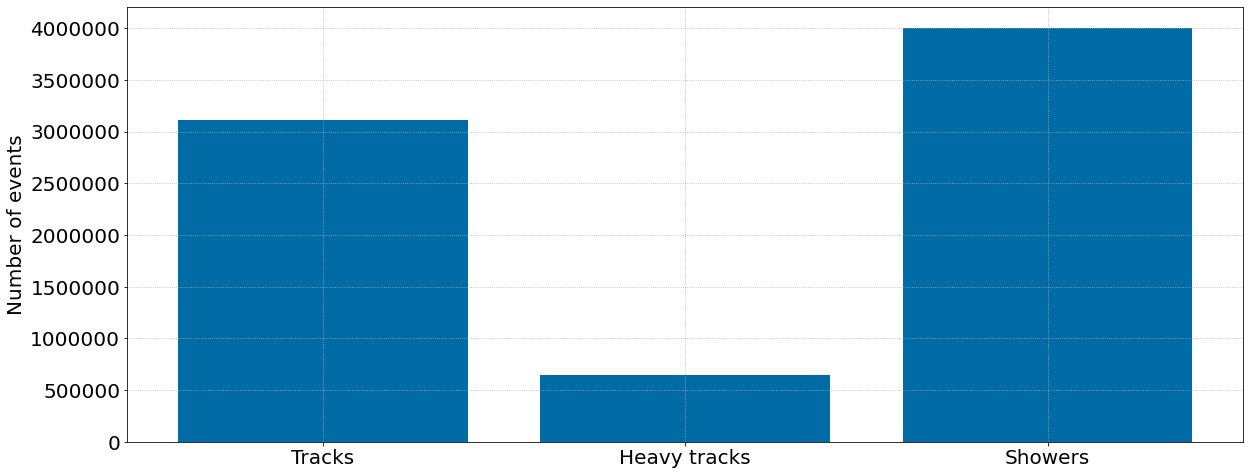

In [11]:
## Make histogram of Tracks, Heavy tracks and Showers

fig, ax = plt.subplots(figsize=(20,8))
plt.rcParams.update({'font.size': 20})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

    ax.ticklabel_format(useOffset=False, style='plain')

class_name = ["Tracks", "Heavy tracks", "Showers"]
class_values = [num_total_track_events, num_total_heavy_track_events, num_total_shower_events]

ax.bar(class_name, class_values)

ax.set_ylabel('Number of events')
ax.grid(linestyle='dotted')
plt.savefig("plots" + output_directory + "/histo_class_count.png")


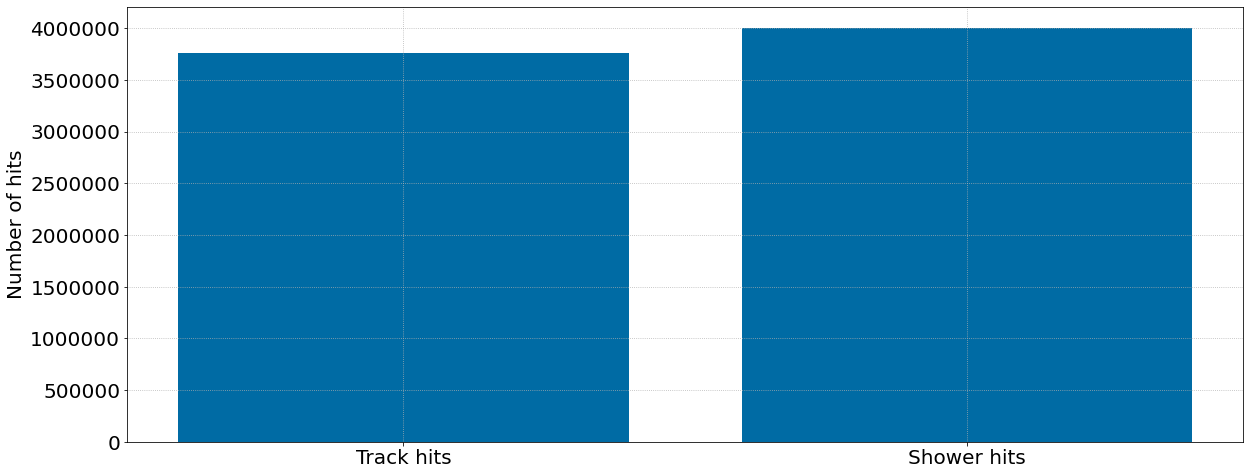

In [12]:
## Make histogram of Tracks, Heavy tracks and Showers

fig, ax = plt.subplots(figsize=(20,8))
plt.rcParams.update({'font.size': 20})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

    ax.ticklabel_format(useOffset=False, style='plain')

class_name = ["Track hits", "Shower hits"]
class_values = [num_total_track_events+num_total_heavy_track_events, num_total_shower_events]

ax.bar(class_name, class_values)

#ax.set_yscale('log')

ax.set_ylabel('Number of hits')
ax.grid(linestyle='dotted')
plt.savefig("plots" + output_directory + "/histo_class_track_shower_count.png")


Tracks: muon, positive muon, positive pion, negative pion
Heavy tracks: proton, positive pion, negative pion
Showers: electron, positron 


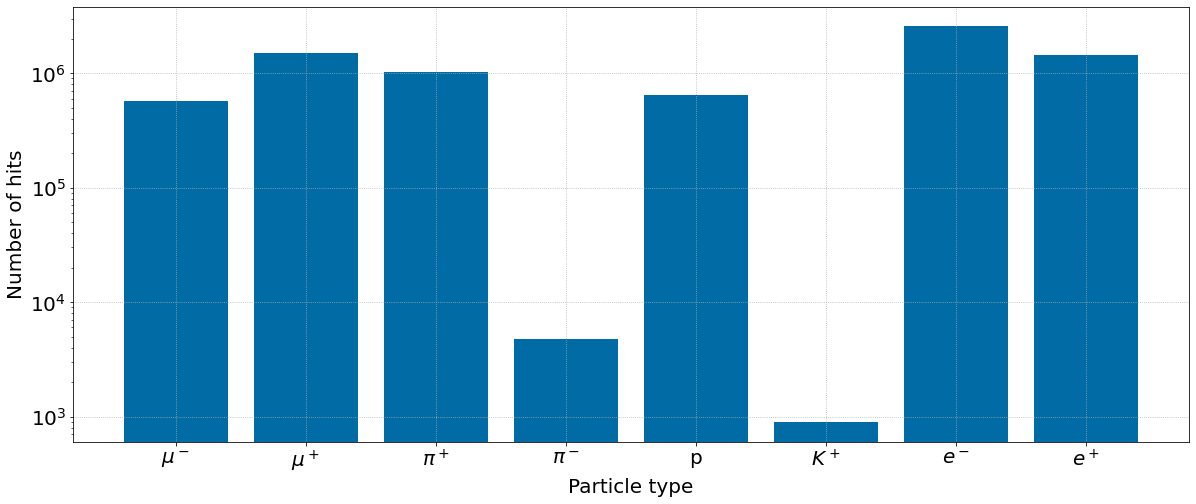

In [14]:
## Make histogram of particle types

fig, ax = plt.subplots(figsize=(20,8))
plt.rcParams.update({'font.size': 20})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

    ax.ticklabel_format(useOffset=False, style='plain')

    
class_name = ["$\mu^-$", "$\mu^+$", "$\pi^+$", "$\pi^-$", "p", "$K^+$", "$e^-$", "$e^+$" ]
class_values = [num_muon_events, num_positve_muon_events, num_positive_pion_events, num_negative_pion_events, num_proton_events, num_positive_kaon_events, num_electron_events, num_postiron_events]

ax.bar(class_name, class_values)

ax.set_xlabel('Particle type')
ax.set_ylabel('Number of hits')
ax.grid(linestyle='dotted')
ax.set_yscale('log')

plt.savefig("plots" + output_directory + "/histo_particle_type_count.png")

print("Tracks: muon, positive muon, positive pion, negative pion")
print("Heavy tracks: proton, positive pion, negative pion")
print("Showers: electron, positron ")

In [ ]:
# Calling DataFrame constructor after zipping both lists, with columns specified
import pandas as pd

d = {'neighboring_nodes_3cm':neighbour_3, 'neighboring_nodes_10cm':neighbour_10, 'neighboring_nodes_30cm':neighbour_30, 'charge':charge_map, 'dot_product':dot_product, 'angle':angle, 'charge_distance_3cm':charge_distance1, 'charge_distance_10cm':charge_distance2, 'charge_distance_30cm':charge_distance3, }

df = pd.DataFrame(d)

#df = pd.DataFrame(list(zip(neighbour_3, neighbour_10, neighbour_30, charge_map, dot_product, angle, charge_distance1, charge_distance2, charge_distance3),
#               columns = ['Neighboring_nodes_3cm', 'Neighboring_nodes_10cm', 'Neighboring_nodes_30cm', 'Charge', 'Dot_product', 'Angle', 'Charge_distance_3cm', 'Charge_distance_10cm', 'Charge_distance_30cm']))


In [ ]:
## Correlation matrix for both tracks and showers together
import seaborn as sn
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:

neighbour_3_track = []
neighbour_10_track = []
neighbour_30_track = []

charge_map_track = []
dot_product_track = []
angle_track = []

charge_distance1_track = []
charge_distance2_track = []
charge_distance3_track = []


neighbour_3_shower = []
neighbour_10_shower = []
neighbour_30_shower = []

charge_map_shower = []
dot_product_shower = []
angle_shower = []

charge_distance1_shower = []
charge_distance2_shower = []
charge_distance3_shower = []




print("Processing features separately for tracks and showers")    


for x in range(len(x_coordinate)):
      if label[x] == 0:
        neighbour_3_track.append(neighbour_3[x])
        neighbour_10_track.append(neighbour_10[x])
        neighbour_30_track.append(neighbour_30[x])
        charge_map_track.append(charge_map[x])
        dot_product_track.append(dot_product[x])
        angle_track.append(angle[x])
        charge_distance1_track.append(charge_distance1[x])
        charge_distance2_track.append(charge_distance2[x])
        charge_distance3_track.append(charge_distance3[x])        
      elif label[x] == 1:
        neighbour_3_track.append(neighbour_3[x])
        neighbour_10_track.append(neighbour_10[x])
        neighbour_30_track.append(neighbour_30[x])
        charge_map_track.append(charge_map[x])
        dot_product_track.append(dot_product[x])
        angle_track.append(angle[x])
        charge_distance1_track.append(charge_distance1[x])
        charge_distance2_track.append(charge_distance2[x])
        charge_distance3_track.append(charge_distance3[x])  
      else:
        neighbour_3_shower.append(neighbour_3[x])
        neighbour_10_shower.append(neighbour_10[x])
        neighbour_30_shower.append(neighbour_30[x])
        charge_map_shower.append(charge_map[x])
        dot_product_shower.append(dot_product[x])
        angle_shower.append(angle[x])
        charge_distance1_shower.append(charge_distance1[x])
        charge_distance2_shower.append(charge_distance2[x])
        charge_distance3_shower.append(charge_distance3[x])  

print("Length of charge_distance1_track: ", len(charge_distance1_track))
#print("Length of data_heavy_track: ", len(data_heavy_track_X))
print("Length of charge_distance1_shower: ", len(charge_distance1_shower))

In [ ]:
d_track = {'neighboring_nodes_3cm':neighbour_3_track, 'neighboring_nodes_10cm':neighbour_10_track, 'neighboring_nodes_30cm':neighbour_30_track, 'charge':charge_map_track, 'dot_product':dot_product_track, 'angle':angle_track, 'charge_distance_3cm':charge_distance1_track, 'charge_distance_10cm':charge_distance2_track, 'charge_distance_30cm':charge_distance3_track}

d_shower = {'neighboring_nodes_3cm':neighbour_3_shower, 'neighboring_nodes_10cm':neighbour_10_shower, 'neighboring_nodes_30cm':neighbour_30_shower, 'charge':charge_map_shower, 'dot_product':dot_product_shower, 'angle':angle_shower, 'charge_distance_3cm':charge_distance1_shower, 'charge_distance_10cm':charge_distance2_shower, 'charge_distance_30cm':charge_distance3_shower }

df_track = pd.DataFrame(d_track)
df_shower = pd.DataFrame(d_shower)


In [ ]:

## Correlation matrix for tracks

corrMatrix_track = df_track.corr()
sn.heatmap(corrMatrix_track, annot=True)
plt.show()

In [ ]:

## Correlation matrix for showers

corrMatrix_shower = df_shower.corr()
sn.heatmap(corrMatrix_shower, annot=True)
plt.show()

In [ ]:
##
##  Get overall 3D coordinates
##


data_track_X = []
data_track_Y = []
data_track_Z = []

data_heavy_track_X = []
data_heavy_track_Y = []
data_heavy_track_Z = []

data_shower_X = []
data_shower_Y = []
data_shower_Z = []

print("Processing X,Y,Z COORDINATES")    


for x in range(len(x_coordinate)):
      if label[x] == 0:
        data_track_X.append(x_coordinate[x])
        data_track_Y.append(y_coordinate[x])
        data_track_Z.append(z_coordinate[x])
      elif label[x] == 1:
        data_heavy_track_X.append(x_coordinate[x])
        data_heavy_track_Y.append(y_coordinate[x])
        data_heavy_track_Z.append(z_coordinate[x])    
      else:
        data_shower_X.append(x_coordinate[x])
        data_shower_Y.append(y_coordinate[x])
        data_shower_Z.append(z_coordinate[x])

print("Length of data_track: ", len(data_track_X))
print("Length of data_heavy_track: ", len(data_heavy_track_X))
print("Length of data_shower: ", len(data_shower_X))



In [ ]:
##
##  Get 3D coordinates for EACH particle type
##


data_track_X_muon = []
data_track_Y_muon = []
data_track_Z_muon = []


data_track_X_positive_muon = []
data_track_Y_positive_muon = []
data_track_Z_positive_muon = []


data_track_X_positive_pion = []
data_track_Y_positive_pion = []
data_track_Z_positive_pion = []


data_track_X_negative_pion = []
data_track_Y_negative_pion = []
data_track_Z_negative_pion = []
 

data_heavy_track_X_proton = []
data_heavy_track_Y_proton = []
data_heavy_track_Z_proton = []

data_heavy_track_X_positive_kaon = []
data_heavy_track_Y_positive_kaon = []
data_heavy_track_Z_positive_kaon = []

data_heavy_track_X_negative_kaon = []
data_heavy_track_Y_negative_kaon = []
data_heavy_track_Z_negative_kaon = []


data_shower_X_electron = []
data_shower_Y_electron = []
data_shower_Z_electron = []

data_shower_X_positron = []
data_shower_Y_positron = []
data_shower_Z_positron = []

print("Processing X,Y,Z COORDINATES")    


for x in range(len(x_coordinate)):
      if pdg[x] == 13:
        data_track_X_muon.append(x_coordinate[x])
        data_track_Y_muon.append(y_coordinate[x])
        data_track_Z_muon.append(z_coordinate[x])
      elif pdg[x] == -13:
        data_track_X_positive_muon.append(x_coordinate[x])
        data_track_Y_positive_muon.append(y_coordinate[x])
        data_track_Z_positive_muon.append(z_coordinate[x])         
      elif pdg[x] == 211:
        data_track_X_positive_pion.append(x_coordinate[x])
        data_track_Y_positive_pion.append(y_coordinate[x])
        data_track_Z_positive_pion.append(z_coordinate[x]) 
      elif pdg[x] == -211:
        data_track_X_negative_pion.append(x_coordinate[x])
        data_track_Y_negative_pion.append(y_coordinate[x])
        data_track_Z_negative_pion.append(z_coordinate[x])       
      elif pdg[x] == 2212:
        data_heavy_track_X_proton.append(x_coordinate[x])
        data_heavy_track_Y_proton.append(y_coordinate[x])
        data_heavy_track_Z_proton.append(z_coordinate[x]) 
      elif pdg[x] == 321:
        data_heavy_track_X_positive_kaon.append(x_coordinate[x])
        data_heavy_track_Y_positive_kaon.append(y_coordinate[x])
        data_heavy_track_Z_positive_kaon.append(z_coordinate[x])         
      elif pdg[x] == -321:
        data_heavy_track_X_negative_kaon.append(x_coordinate[x])
        data_heavy_track_Y_negative_kaon.append(y_coordinate[x])
        data_heavy_track_Z_negative_kaon.append(z_coordinate[x]) 
      elif pdg[x] == 11:
        data_shower_X_electron.append(x_coordinate[x])
        data_shower_Y_electron.append(y_coordinate[x])
        data_shower_Z_electron.append(z_coordinate[x])         
      elif pdg[x] == -11:
        data_shower_X_positron.append(x_coordinate[x])
        data_shower_Y_positron.append(y_coordinate[x])
        data_shower_Z_positron.append(z_coordinate[x])         
                
        
print("Finished processing X,Y,Z COORDINATES")    
        


In [ ]:
## PLOTTING 3D COORDINATES

""""

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data_track_X, data_track_Y, data_track_Z, color='firebrick', label="Track", marker="o", s=1)
ax.scatter(data_heavy_track_X, data_heavy_track_Y, data_heavy_track_Z, color='forestgreen', label="Heavy Track", marker="d", s=1)
ax.scatter(data_shower_X, data_shower_Y, data_shower_Z, color='royalblue', label="Shower", marker="X", s=1)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.grid()
plt.legend(loc='best')
plt.show()
#plt.savefig("plots_no_beam/plot_3d.png")
"""

In [ ]:
# Plotting X,Y,Z sections for tracks, heavy tracks and showers


fig = plt.figure(figsize=(35,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)



## =====================================
##       X vs Y
## =====================================

ax = fig.add_subplot(1, 3, 1)
plt.scatter(data_track_X, data_track_Y, color='firebrick', label="Track", marker="o", s=10)
plt.scatter(data_heavy_track_X, data_heavy_track_Y, color='forestgreen', label="Heavy Track", marker="d", s=10)
plt.scatter(data_shower_X, data_shower_Y, color='royalblue', label="Shower", marker="X", s=10)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
plt.title("X vs Y")
plt.xlabel("X coordinate")
plt.ylabel('Y coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



## =====================================
##       X vs Z
## =====================================


ax = fig.add_subplot(1, 3, 2)
plt.scatter(data_track_X, data_track_Z, color='firebrick', label="Track", marker="o", s=10)
plt.scatter(data_heavy_track_X, data_heavy_track_Z, color='forestgreen', label="Heavy Track", marker="d", s=10)
plt.scatter(data_shower_X, data_shower_Z, color='royalblue', label="Shower", marker="X", s=10)


ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
plt.title("X vs Z")
plt.xlabel("X coordinate")
plt.ylabel('Z coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



## =====================================
##       Y vs Z
## =====================================


ax = fig.add_subplot(1, 3, 3)

plt.scatter(data_track_Y, data_track_Z, color='firebrick', label="Track", marker="o", s=10)
plt.scatter(data_heavy_track_Y, data_heavy_track_Z, color='forestgreen', label="Heavy Track", marker="d", s=10)
plt.scatter(data_shower_Y, data_shower_Z, color='royalblue', label="Shower", marker="X", s=10)


ax.set_xlabel('Y Label')
ax.set_ylabel('Z Label')
plt.title("Y vs Z")
plt.xlabel("Y coordinate")
plt.ylabel('Z coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom




plt.savefig("plots" + output_directory + "/plot_2d_coordinates.png")



In [ ]:
## Plotting X and Y for tracks

fig = plt.figure(figsize=(35,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)



## =====================================
##       TRACKS
## =====================================

ax = fig.add_subplot(1, 3, 1)
plt.scatter(data_track_X_positive_muon, data_track_Y_positive_muon, color='royalblue', label="Positive muon", marker="X", s=10, alpha=0.5)
plt.scatter(data_track_X_muon, data_track_Y_muon, color='firebrick', label="Muon", marker="o", s=10, alpha=0.5)
plt.scatter(data_track_X_positive_pion, data_track_Y_positive_pion, color='forestgreen', label="Positive pion", marker="d", s=10, alpha=0.5)
plt.scatter(data_track_X_negative_pion, data_track_Y_negative_pion, color='gold', label="Negative pion", marker="v", s=10, alpha=0.5)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
plt.title("Tracks")
plt.xlabel("X coordinate")
plt.ylabel('Y coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



## =====================================
##       Heavy Tracks
## =====================================



ax = fig.add_subplot(1, 3, 2)
plt.scatter(data_heavy_track_X_proton, data_heavy_track_Y_proton, color='firebrick', label="Proton", marker="o", s=10, alpha=0.5)
plt.scatter(data_heavy_track_X_positive_kaon, data_heavy_track_Y_positive_kaon, color='royalblue', label="Positive kaon", marker="X", s=10, alpha=0.5)
plt.scatter(data_heavy_track_X_negative_kaon, data_heavy_track_Y_negative_kaon, color='forestgreen', label="Negative kaon", marker="d", s=10, alpha=0.5)



ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
plt.title("Heavy Tracks")
plt.xlabel("X coordinate")
plt.ylabel('Y coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom



## =====================================
##       SHOWERS
## =====================================


ax = fig.add_subplot(1, 3, 3)

plt.scatter(data_shower_X_electron, data_shower_Y_electron, color='firebrick', label="Electron", marker="o", s=10, alpha=0.5)
plt.scatter(data_shower_X_positron, data_shower_Y_positron, color='royalblue', label="Positron", marker="X", s=10, alpha=0.5)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
plt.title("Showers")
plt.xlabel("X coordinate")
plt.ylabel('Y coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom




plt.savefig("plots" + output_directory + "/plot_2d_X_Y.png")


In [ ]:
## Plotting X and Z for tracks

fig = plt.figure(figsize=(35,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

"""
### Some fitting

## Define the beam line
slope = np.tan(11*np.pi/18)
mn = -200
mx = 50
#mn=np.min(data_heavy_track_X)
#mx=np.max(data_heavy_track_Z)
x1=np.linspace(mn,mx,500)
y1=slope*x1-0.2347


## Polynomial fit
from scipy import stats
gradient, intercept, r_value, p_value, std_err = stats.linregress(data_track_X_negative_pion,data_track_Z_negative_pion)
#mn=np.min(data_track_X_negative_pion)
#mx=np.max(data_track_Z_negative_pion)
mn = -200
mx = 50
x2=np.linspace(mn,mx,500)
y2=gradient*x1+intercept
"""


## =====================================
##       TRACKS
## =====================================


ax = fig.add_subplot(1, 3, 1)


plt.scatter(data_track_X_muon, data_track_Z_muon, color='firebrick', label="Muon", marker="o", s=10, alpha=0.5)
plt.scatter(data_track_X_positive_muon, data_track_Z_positive_muon, color='royalblue', label="Positive muon", marker="X", s=10, alpha=0.5)
plt.scatter(data_track_X_positive_pion, data_track_Z_positive_pion, color='forestgreen', label="Positive pion", marker="d", s=10, alpha=0.5)
plt.scatter(data_track_X_negative_pion, data_track_Z_negative_pion, color='gold', label="Negative pion", marker="v", s=10, alpha=0.5)
#plt.plot(x1,y1, color='black', linewidth=5, label="beamline-equation")
#plt.plot(x2,y2, color='purple', linewidth=5, label="beamline-fit")

ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
plt.title("Tracks")
plt.xlabel("X coordinate")
plt.ylabel('Z coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom


## =====================================
##       Heavy tracks
## =====================================

ax = fig.add_subplot(1, 3, 2)
plt.scatter(data_heavy_track_X_proton, data_heavy_track_Z_proton, color='firebrick', label="Proton", marker="o", s=10, alpha=0.5)
plt.scatter(data_heavy_track_X_positive_kaon, data_heavy_track_Z_positive_kaon, color='royalblue', label="Positive kaon", marker="X", s=10, alpha=0.5)
plt.scatter(data_heavy_track_X_negative_kaon, data_heavy_track_Z_negative_kaon, color='forestgreen', label="Negative kaon", marker="d", s=10, alpha=0.5)


ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
plt.title("Heavy Tracks")
plt.xlabel("X coordinate")
plt.ylabel('Z coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom


## =====================================
##       SHOWERS
## =====================================


ax = fig.add_subplot(1, 3, 3)


plt.scatter(data_shower_X_electron, data_shower_Z_electron, color='firebrick', label="Electron", marker="o", s=10, alpha=0.5)
plt.scatter(data_shower_X_positron, data_shower_Z_positron, color='royalblue', label="Positron", marker="X", s=10, alpha=0.5)


ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
plt.title("Showers")
plt.xlabel("X coordinate")
plt.ylabel('Z coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom




plt.savefig("plots" + output_directory + "/plot_2d_X_Z.png")


In [ ]:
## Plotting Y and Z for tracks

fig = plt.figure(figsize=(35,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

## =====================================
##       TRACKS
## =====================================

ax = fig.add_subplot(1, 3, 1)

plt.scatter(data_track_Y_muon, data_track_Z_muon, color='firebrick', label="Muon", marker="o", s=10, alpha=0.5)
plt.scatter(data_track_Y_positive_muon, data_track_Z_positive_muon, color='royalblue', label="Positive muon", marker="X", s=10, alpha=0.5)
plt.scatter(data_track_Y_positive_pion, data_track_Z_positive_pion, color='forestgreen', label="Positive pion", marker="d", s=10, alpha=0.5)
plt.scatter(data_track_Y_negative_pion, data_track_Z_negative_pion, color='gold', label="Negative pion", marker="v", s=10, alpha=0.5)

ax.set_xlabel('Y Label')
ax.set_ylabel('Z Label')
plt.title("Tracks")
plt.xlabel("Y coordinate")
plt.ylabel('Z coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom

## =====================================
##       HEAVY TRACKS
## =====================================

ax = fig.add_subplot(1, 3, 2)
plt.scatter(data_heavy_track_Y_proton, data_heavy_track_Z_proton, color='firebrick', label="Proton", marker="o", s=10, alpha=0.5)
plt.scatter(data_heavy_track_Y_positive_kaon, data_heavy_track_Z_positive_kaon, color='royalblue', label="Positive kaon", marker="X", s=10, alpha=0.5)
plt.scatter(data_heavy_track_Y_negative_kaon, data_heavy_track_Z_negative_kaon, color='forestgreen', label="Negative kaon", marker="d", s=10, alpha=0.5)

ax.set_xlabel('Y Label')
ax.set_ylabel('Z Label')
plt.title("Heavy Tracks")
plt.xlabel("Y coordinate")
plt.ylabel('Z coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom

## =====================================
##       SHOWERS
## =====================================

ax = fig.add_subplot(1, 3, 3)
plt.scatter(data_shower_Y_electron, data_shower_Z_electron, color='firebrick', label="Electron", marker="o", s=10, alpha=0.5)
plt.scatter(data_shower_Y_positron, data_shower_Z_positron, color='royalblue', label="Positron", marker="X", s=10, alpha=0.5)

ax.set_xlabel('Y Label')
ax.set_ylabel('Z Label')
plt.title("Showers")
plt.xlabel("Y coordinate")
plt.ylabel('Z coordinate')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom




plt.savefig("plots" + output_directory + "/plot_2d_Y_Z.png")


# Analysis of the features

In [ ]:
##
##  ANGLE
##

data_track_angle = []
data_heavy_track_angle = []
data_shower_angle = []

print("Processing ANGLE")    

print("\nLength of all the events: ", len(x_coordinate))
for x in range(len(x_coordinate)):
  if label[x] == 0:
    data_track_angle.append(angle[x])
  elif label[x] == 1:
    data_heavy_track_angle.append(angle[x])    
  else:
    data_shower_angle.append(angle[x])

print("Length of data_track: ", len(data_track_angle))
print("Length of data_heavy_track: ", len(data_heavy_track_angle))
print("Length of data_shower: ", len(data_shower_angle))


print("\n Processing ANGLE for each particle type")    


angle_muon = []
angle_positive_muon = []
angle_positive_pion = []
angle_negative_pion = []
angle_tracks = {"muon": angle_muon, "positive_muon": angle_positive_muon, "positive_pion": angle_positive_pion, "negative_pion": angle_negative_pion}

angle_proton = []
angle_positive_kaon = []
angle_negative_kaon = []
angle_heavy_track = {"proton": angle_proton, "positive_kaon": angle_positive_kaon, "negative_kaon": angle_negative_kaon}

angle_electron = []
angle_positron = []
angle_showers = {"electron": angle_electron, "positron": angle_positron }
for x in range(len(x_coordinate)):
  pdgToParticle(angle_tracks, angle_heavy_track, angle_showers, pdg[x], angle[x])


# Some checks 
print("\n\nSOME CHECKS:")
print("Number of spacepoints for shower electrons: ", len(angle_showers["electron"]))
print("Number of spacepoints for shower positrons: ", len(angle_showers["positron"]))
print("Total number of shower particles: ", len(angle_showers["electron"]) + len(angle_showers["positron"]) )



    

In [ ]:
## Plotting angle

bin_size = 100
print("Bin size: ", bin_size)

bin_count_data_shower, bins_data_shower = np.histogram(data_shower_angle, bins=bin_size)          
bin_count_data_track, bins_data_track = np.histogram(data_track_angle, bins=bin_size)          
bin_count_data_heavy_track, bins_data_heavy_track = np.histogram(data_heavy_track_angle, bins=bin_size)          


plt.hist(data_shower_angle, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower", linewidth=2)
plt.hist(data_track_angle, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track", linewidth=2)
plt.hist(data_heavy_track_angle, bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="Heavy Track")

 
#plt.xlim(0,1)
plt.title("Feature: angle")
plt.xlabel("angle")
plt.ylabel('Count')

plt.yscale('log') 

plt.axvline(x=np.pi/8, color='gray', linestyle='--', label=r'$\pi /8$')
plt.axvline(x=2*np.pi/8, color='gray', linestyle='--', label=r'$2\pi /8$')
plt.axvline(x=3*np.pi/8, color='gray', linestyle='--', label=r'$3\pi /8$')
plt.axvline(x=np.pi/2, color='gray', linestyle='--', label=r'$4\pi /8$')
plt.axvline(x=5*np.pi/8, color='gray', linestyle='--', label=r'$5\pi /8$')
plt.axvline(x=6*np.pi/8, color='gray', linestyle='--', label=r'$6\pi /8$')
plt.axvline(x=7*np.pi/8, color='gray', linestyle='--', label=r'$7\pi /8$')


plt.legend(loc='best')
#plt.show()
plt.grid()

plt.savefig("plots" + output_directory + "/angle.png")

In [ ]:
## Plotting angle

bin_size = 100
print("Bin size: ", bin_size)

#data_shower_angle = []
#data_track_angle = []
#data_heavy_track_angle = []


bin_count_data_shower, bins_data_shower = np.histogram(data_shower_angle, bins=bin_size)          
bin_count_data_track, bins_data_track = np.histogram(data_track_angle, bins=bin_size)          
bin_count_data_heavy_track, bins_data_heavy_track = np.histogram(data_heavy_track_angle, bins=bin_size)          

plt.hist(data_shower_angle, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower", linewidth=3)
plt.hist(data_track_angle+data_heavy_track_angle, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track", linewidth=3)
#plt.hist(data_heavy_track_angle, bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="Heavy Track")


#cos_angle_shower = [np.cos(x) for x in data_shower_angle]
#cos_angle_track = [np.cos(x) for x in data_track_angle]
#cos_angle_heavy_track = [np.cos(x) for x in data_heavy_track_angle]

#plt.hist(cos_angle_shower, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower", linewidth=3)
#plt.hist(cos_angle_track+cos_angle_heavy_track, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track", linewidth=3)
#plt.hist(cos_angle_heavy_track, bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="Heavy Track")




 
#plt.xlim(0,1)
plt.title("Feature: angle")
plt.xlabel("Angle [rad]")
plt.ylabel('Count')

plt.yscale('log') 

#plt.axvline(x=np.pi/8, color='gray', linestyle='--', label=r'$\pi /8$')
#plt.axvline(x=2*np.pi/8, color='gray', linestyle='--', label=r'$2\pi /8$')
#plt.axvline(x=3*np.pi/8, color='gray', linestyle='--', label=r'$3\pi /8$')
#plt.axvline(x=np.pi/2, color='gray', linestyle='--', label=r'$4\pi /8$')
#plt.axvline(x=5*np.pi/8, color='gray', linestyle='--', label=r'$5\pi /8$')
#plt.axvline(x=6*np.pi/8, color='gray', linestyle='--', label=r'$6\pi /8$')
#plt.axvline(x=7*np.pi/8, color='gray', linestyle='--', label=r'$7\pi /8$')


plt.legend(loc='best')
#plt.show()
plt.grid()

plt.savefig("plots" + output_directory + "/angle.png")

In [ ]:
## Plotting angle

bin_size = 100
print("Bin size: ", bin_size)

bin_count_data_shower, bins_data_shower = np.histogram(data_shower_angle, bins=bin_size)  
error_data_shower = [np.sqrt(x) for x in bin_count_data_shower]

bin_count_data_track, bins_data_track = np.histogram(data_track_angle, bins=bin_size)          
bin_count_data_heavy_track, bins_data_heavy_track = np.histogram(data_heavy_track_angle, bins=bin_size)          



#plt.errorbar(x=bins_data_shower, y=bins_data_shower, yerr=0.01, histtype='step', stacked=True, color='royalblue', label="Shower")
plt.errorbar(x=bins_data_shower[1:], y=bin_count_data_shower, yerr=1000, color='royalblue', label="Shower",  fmt='none',  ls="--")
#plt.errorbar(y=data_track_angle, yerr=0.01, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track")
#plt.errorbar(y=data_heavy_track_angle, yerr=0.01, bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="Heavy Track")

 
#plt.xlim(0,1)
plt.title("Feature: angle")
plt.xlabel("angle")
plt.ylabel('Count')

plt.yscale('log') 

plt.axvline(x=np.pi/8, color='gray', linestyle='--', label=r'$\pi /8$')
plt.axvline(x=2*np.pi/8, color='gray', linestyle='--', label=r'$2\pi /8$')
plt.axvline(x=3*np.pi/8, color='gray', linestyle='--', label=r'$3\pi /8$')
plt.axvline(x=np.pi/2, color='gray', linestyle='--', label=r'$4\pi /8$')
plt.axvline(x=5*np.pi/8, color='gray', linestyle='--', label=r'$5\pi /8$')
plt.axvline(x=6*np.pi/8, color='gray', linestyle='--', label=r'$6\pi /8$')
plt.axvline(x=7*np.pi/8, color='gray', linestyle='--', label=r'$7\pi /8$')


plt.legend(loc='best')
#plt.show()
plt.grid()


plt.savefig("plots" + output_directory + "/angle_v2.png")

In [ ]:
# Root histogram of the angle feature

plotFileName = "plots" + output_directory +"/root_angle.pdf" 

bin_size = 100
print("Bin size: ", bin_size)


## COLORS
# tcolor = root.gROOT.GetColor(10)
# color_forest_green = tcolor.SetRGB(13.3, 54.5, 13.3)
# Firebrick: angle_histo.SetLineColor(46)
# Royalblue: angle_histo.SetLineColor(38)
# Forestgreen: angle_histo.SetLineColor(8)

## MARKERS

#   h1->SetMarkerStyle(kFullCircle)
#   h2->SetMarkerStyle(kFullSquare);
#   h3->SetMarkerStyle(kFullTriangleUp);
#   h4->SetMarkerStyle(kFullTriangleDown);
#   h5->SetMarkerStyle(kOpenCircle);

width_canvas = 1024
height_canvas = 780

canvas = root.TCanvas("Feature: angle", "c", width_canvas, height_canvas)
canvas.cd()
canvas.Print(plotFileName+"[") #several plots to the same file

hist_min = np.min(data_shower_angle)
hist_max = np.max(data_shower_angle)

hist_max_heavy_track = np.max(data_heavy_track_angle)
hist_max_track = np.max(data_track_angle)


angle_hist_shower = root.TH1F("h", "Feature: angle", bin_size, 0, hist_max);
angle_hist_heavy_track = root.TH1F("h", "Feature: angle", bin_size, 0, hist_max_heavy_track);
angle_hist_track = root.TH1F("h", "Feature: angle", bin_size, 0, hist_max_track);

angle_hist_shower.GetXaxis().SetTitle("angle");
angle_hist_shower.GetYaxis().SetTitle("count");



for x in data_shower_angle:
    angle_hist_shower.Fill(x)

for x in data_heavy_track_angle:
    angle_hist_heavy_track.Fill(x)

for x in data_track_angle:
    angle_hist_track.Fill(x)


angle_hist_shower.SetLineColor(38)
angle_hist_shower.SetLineWidth (2)
angle_hist_shower.SetOption("E")

angle_hist_heavy_track.SetLineColor(8)
angle_hist_heavy_track.SetLineWidth (2)
angle_hist_heavy_track.SetOption("E")

angle_hist_track.SetLineColor(46)
angle_hist_track.SetLineWidth (2)
angle_hist_track.SetOption("E")

canvas.SetLogy(True)
#angle_hist_shower.Draw("pe ,SameHist")
angle_hist_shower.Draw("hist")
# TO DRAW ERROR
#angle_hist_shower.Draw("e2")
#angle_hist_shower.Draw("e1p same")

angle_hist_heavy_track.Draw("SameHist")
angle_hist_track.Draw("SameHist")


# Legend
#root.gPad.BuildLegend() #automatic legend
leg = root.TLegend(.1, .7, .3, .9, "")
leg.SetFillColor(0)
leg.AddEntry(angle_hist_shower, "Shower")
leg.AddEntry(angle_hist_heavy_track, "Heavy Track")
leg.AddEntry(angle_hist_track, "Track")
leg.Draw("Same");


canvas.Print(plotFileName)
canvas.Print(plotFileName+"]")

canvas.Draw()



In [ ]:
## Plotting angle for shower only to understand the strange features at fixed angles

bin_size = 100
print("Bin size: ", bin_size)

plt.hist(data_shower_angle, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower - all")
plt.hist(angle_showers["electron"], bins=bin_size, histtype='step', stacked=True, color='firebrick', label="electron")
plt.hist(angle_showers["positron"], bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="positron")


#plt.xlim(0,1)
plt.title("Feature: angle for shower events")
plt.xlabel("angle")
plt.ylabel('Count')

plt.yscale('log') 


plt.axvline(x=np.pi/8, color='gray', linestyle='--', label=r'$\pi /8$')
plt.axvline(x=2*np.pi/8, color='gray', linestyle='--', label=r'$2\pi /8$')
plt.axvline(x=3*np.pi/8, color='gray', linestyle='--', label=r'$3\pi /8$')
plt.axvline(x=np.pi/2, color='gray', linestyle='--', label=r'$4\pi /8$')
plt.axvline(x=5*np.pi/8, color='gray', linestyle='--', label=r'$5\pi /8$')
plt.axvline(x=6*np.pi/8, color='gray', linestyle='--', label=r'$6\pi /8$')
plt.axvline(x=7*np.pi/8, color='gray', linestyle='--', label=r'$7\pi /8$')


plt.legend(loc='best')
#plt.show()
plt.grid()
plt.savefig("plots" + output_directory + "/angle_shower.png")

In [ ]:
bin_size = 100
print("Bin size: ", bin_size)

cos_angle_shower = [np.cos(x) for x in data_shower_angle]
cos_angle_track = [np.cos(x) for x in data_track_angle]
cos_angle_heavy_track = [np.cos(x) for x in data_heavy_track_angle]

plt.hist(cos_angle_shower, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower")
plt.hist(cos_angle_track, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track")
plt.hist(cos_angle_heavy_track, bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="Heavy Track")


#plt.xlim(0,1)
plt.title("Feature: cos(angle)")
plt.xlabel("cos(angle)")
plt.ylabel('Count')
plt.legend(loc='best')

plt.grid()
plt.savefig("plots" + output_directory + "/cosine_angle.png")

In [ ]:
## Plotting cos(angle) vs position

cos_angle_shower = [np.cos(x) for x in data_shower_angle]
cos_angle_track = [np.cos(x) for x in data_track_angle]
cos_angle_heavy_track = [np.cos(x) for x in data_heavy_track_angle]


fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 3, 1)
plt.scatter(data_track_X, cos_angle_track, color='firebrick', label="Track", marker="o", s=10, alpha=0.5)
plt.scatter(data_heavy_track_X, cos_angle_heavy_track, color='forestgreen', label="Heavy Track", marker="d", s=10, alpha=0.5)
plt.scatter(data_shower_X, cos_angle_shower, color='royalblue', label="Shower", marker="X", s=10, alpha=0.5)

plt.xlabel("X coordinate")
plt.ylabel('cos angle')
#plt.legend(loc='best')
plt.grid()

ax = fig.add_subplot(2, 3, 2)
plt.scatter(data_track_Y, cos_angle_track, color='firebrick', label="Track", marker="o", s=10, alpha=0.5)
plt.scatter(data_heavy_track_Y, cos_angle_heavy_track, color='forestgreen', label="Heavy Track", marker="d", s=10, alpha=0.5)
plt.scatter(data_shower_Y, cos_angle_shower, color='royalblue', label="Shower", marker="X", s=10, alpha=0.5)

plt.xlabel("Y coordinate")
plt.ylabel('cos angle')
#plt.legend(loc='best')
plt.grid()


ax = fig.add_subplot(2, 3, 3)
plt.scatter(data_track_Z, cos_angle_track, color='firebrick', label="Track", marker="o", s=10, alpha=0.5)
plt.scatter(data_heavy_track_Z, cos_angle_heavy_track, color='forestgreen', label="Heavy Track", marker="d", s=10, alpha=0.5)
plt.scatter(data_shower_Z, cos_angle_shower, color='royalblue', label="Shower", marker="X", s=10, alpha=0.5)

plt.xlabel("Z coordinate")
plt.ylabel('cos angle')
#plt.legend(loc='best')
plt.grid()

plt.savefig("plots" + output_directory + "/cosine_position.png")

In [ ]:
##
##  DOT PRODUCT
##

data_track_dot = []
data_heavy_track_dot = []
data_shower_dot = []
print("Processing DOT PRODUCT")    

print("\nLength of all the events: ", len(x_coordinate))
counter_range = 0

for x in range(len(x_coordinate)):
 if -2 <= dot_product[x] <= 2:
  counter_range += 1
  if label[x] == 0:
    data_track_dot.append(dot_product[x])
  elif label[x] == 1:
    data_heavy_track_dot.append(dot_product[x])    
  else:
    data_shower_dot.append(dot_product[x])

print("Length of data_track: ", len(data_track_dot))
print("Length of data_heavy_track: ", len(data_heavy_track_dot))
print("Length of data_shower: ", len(data_shower_dot))
print("Maximum data_track: ", max(data_track_dot))
print("Maximum data_heavy_track: ", max(data_heavy_track_dot))
print("Maximum data_shower: ", max(data_shower_dot))
print("Number of entries between (-2,2): ", counter_range , " which corresponds to ", 100*counter_range/len(x_coordinate), " %")

In [ ]:
bin_size = 300
print("Bin size: ", bin_size)

plt.hist(data_shower_dot, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower", linewidth=3)
plt.hist(data_track_dot+data_heavy_track_dot, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track", linewidth=3)
#plt.hist(data_heavy_track_dot, bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="Heavy Track")

# ==========================
#        CAREFUL
# ==========================
# plotting a different xlim
plt.xlim(-1,1)
plt.title("Feature: dot product")
plt.xlabel(r"Dot product [$cm^2$]")
plt.ylabel('Count')
plt.legend(loc='best')
#plt.show()
plt.grid()
plt.savefig("plots" + output_directory + "/dot_product.png")


In [ ]:
##
##  CHARGE MAP
##

data_track_charge = []
data_heavy_track_charge = []
data_shower_charge = []
print("Processing  CHARGE MAP")    

print("\nLength of all the events: ", len(x_coordinate))
counter_range = 0
for x in range(len(x_coordinate)):
 if charge_map[x] <= 2000:
  counter_range += 1
  if label[x] == 0:
    data_track_charge.append(charge_map[x])
  elif label[x] == 1:
    data_heavy_track_charge.append(charge_map[x])        
  else:
    data_shower_charge.append(charge_map[x])

print("Length of data_track: ", len(data_track_charge))
print("Length of data_heavy_track: ", len(data_heavy_track_charge))
print("Length of data_shower: ", len(data_shower_charge))
print("Maximum data_track: ", max(data_track_charge))
print("Maximum data_heavy_track: ", max(data_heavy_track_charge))
print("Minimum data_shower: ", max(data_shower_charge))
print("Entries with charge less than 2000: ", counter_range , " which corresponds to ", 100*counter_range/len(x_coordinate), " %")


In [ ]:
bin_size = 100
print("Bin size: ", bin_size)

plt.hist(data_shower_charge, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower")
plt.hist(data_track_charge, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track")
plt.hist(data_heavy_track_charge, bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="Heavy Track")

plt.title("Feature: charge map")
plt.xlabel("Charge map")
plt.ylabel('Count')
plt.legend(loc='best')

plt.grid()
plt.savefig("plots" + output_directory + "/charge_map.png")

In [ ]:
bin_size = 100
print("Bin size: ", bin_size)


plt.hist(data_shower_charge, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower hits", linewidth=3)
plt.hist(data_track_charge+data_heavy_track_charge, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track hits", linewidth=3)


plt.title("Feature: charge deposition")
plt.xlabel(r"Charge deposition [1000e]")
plt.ylabel('Count')
plt.legend(loc='best')

plt.xlim([0, 500])

plt.grid()
plt.savefig("plots" + output_directory + "/charge_map.png")

# Neighboring nodes

In [ ]:
##
##  Neighbouring nodes
##

data_track_neighbour1 = []
data_heavy_track_neighbour1 = []
data_shower_neighbour1 = []

data_track_neighbour2 = []
data_heavy_track_neighbour2 = []
data_shower_neighbour2 = []

data_track_neighbour3 = []
data_heavy_track_neighbour3 = []
data_shower_neighbour3 = []

print("Processing  NEIGHBOURING NODES")    

print("\nLength of all the events: ", len(x_coordinate))
for x in range(len(x_coordinate)):
  if label[x] == 0:
    data_track_neighbour1.append(neighbour_3[x])
    data_track_neighbour2.append(neighbour_10[x])
    data_track_neighbour3.append(neighbour_30[x])    
  elif label[x] == 1:
    data_heavy_track_neighbour1.append(neighbour_3[x])
    data_heavy_track_neighbour2.append(neighbour_10[x])
    data_heavy_track_neighbour3.append(neighbour_30[x])   
  else:
    data_shower_neighbour1.append(neighbour_3[x])
    data_shower_neighbour2.append(neighbour_10[x])
    data_shower_neighbour3.append(neighbour_30[x])   
    
print("Length of data_track: ", len(data_track_neighbour1))
print("Length of data_heavy_track: ", len(data_heavy_track_neighbour1))
print("Length of data_shower: ", len(data_shower_neighbour1))




print("Processing neighboring nodes for each particle type")    


neighbour_3_muon = []
neighbour_3_positive_muon = []
neighbour_3_positive_pion = []
neighbour_3_negative_pion = []
neighbour_3_tracks = {"muon": neighbour_3_muon, "positive_muon": neighbour_3_positive_muon, "positive_pion": neighbour_3_positive_pion, "negative_pion": neighbour_3_negative_pion}

neighbour_3_proton = []
neighbour_3_positive_kaon = []
neighbour_3_negative_kaon = []
neighbour_3_heavy_track = {"proton": neighbour_3_proton, "positive_kaon": neighbour_3_positive_kaon, "negative_kaon": neighbour_3_negative_kaon}

neighbour_3_electron = []
neighbour_3_positron = []
neighbour_3_showers = {"electron": neighbour_3_electron, "positron": neighbour_3_positron }

for x in range(len(x_coordinate)):
  pdgToParticle(neighbour_3_tracks, neighbour_3_heavy_track, neighbour_3_showers, pdg[x], neighbour_3[x])

# Some checks 
print("\n\nSOME CHECKS:")
print("Length of shower electrons: ", len(neighbour_3_showers["electron"]))
print("Length of shower positrons: ", len(neighbour_3_showers["positron"]))
print("Total number of shower particles: ", len(neighbour_3_showers["electron"]) + len(neighbour_3_showers["positron"]) )


In [ ]:
## RADIUS 3 cm

bin_size = 100
print("Bin size: ", bin_size)

data_shower_neighbour1_array = np.array(data_shower_neighbour1)
data_track_neighbour1_array = np.array(data_track_neighbour1+data_heavy_track_neighbour1)

d1 = np.diff(np.unique(data_shower_neighbour1_array)).min()
d2 = np.diff(np.unique(data_track_neighbour1_array)).min()


data_shower_neighbour1_left_of_first_bin = data_shower_neighbour1_array.min() - float(d1)/2
data_shower_neighbour1_right_of_last_bin = data_shower_neighbour1_array.max() + float(d1)/2

data_track_neighbour1_left_of_first_bin = data_track_neighbour1_array.min() - float(d2)/2
data_track_neighbour1_right_of_last_bin = data_track_neighbour1_array.max() + float(d2)/2



plt.hist(data_shower_neighbour1_array, np.arange(data_shower_neighbour1_left_of_first_bin, data_shower_neighbour1_right_of_last_bin + d1, d1), histtype='step', stacked=True, color='royalblue', label="Shower")
plt.hist(data_track_neighbour1_array, np.arange(data_track_neighbour1_left_of_first_bin, data_track_neighbour1_right_of_last_bin + d2, d2), histtype='step', stacked=True, color='firebrick', label="Track")


#plt.xlim(0,1)
plt.title("Feature: neighbour_3")
plt.xlabel("Number of nodes")
plt.ylabel('Count')
plt.legend(loc='best')
#plt.show()
plt.grid()
plt.savefig("plots" + output_directory + "/neighbour_3.png")



In [ ]:
## RADIUS 3 cm

bin_size = 100
print("Bin size: ", bin_size)

data_shower_neighbour1_array = np.array(data_shower_neighbour1)
data_track_neighbour1_array = np.array(data_track_neighbour1)
data_heavy_track_neighbour1_array = np.array(data_heavy_track_neighbour1)

d1 = np.diff(np.unique(data_shower_neighbour1_array)).min()
d2 = np.diff(np.unique(data_track_neighbour1_array)).min()
d3 = np.diff(np.unique(data_heavy_track_neighbour1_array)).min()

data_shower_neighbour1_left_of_first_bin = data_shower_neighbour1_array.min() - float(d1)/2
data_shower_neighbour1_right_of_last_bin = data_shower_neighbour1_array.max() + float(d1)/2

data_track_neighbour1_left_of_first_bin = data_track_neighbour1_array.min() - float(d2)/2
data_track_neighbour1_right_of_last_bin = data_track_neighbour1_array.max() + float(d2)/2

data_heavy_track_neighbour1_left_of_first_bin = data_heavy_track_neighbour1_array.min() - float(d3)/2
data_heavy_track_neighbour1_right_of_last_bin = data_heavy_track_neighbour1_array.max() + float(d3)/2



plt.hist(data_shower_neighbour1_array, np.arange(data_shower_neighbour1_left_of_first_bin, data_shower_neighbour1_right_of_last_bin + d1, d1), histtype='step', stacked=True, color='royalblue', label="Shower")
plt.hist(data_track_neighbour1_array, np.arange(data_track_neighbour1_left_of_first_bin, data_track_neighbour1_right_of_last_bin + d2, d2), histtype='step', stacked=True, color='firebrick', label="Track")
plt.hist(data_heavy_track_neighbour1_array, np.arange(data_heavy_track_neighbour1_left_of_first_bin, data_heavy_track_neighbour1_right_of_last_bin + d3, d3), histtype='step', stacked=True, color='forestgreen', label="Heavy Track")


#plt.xlim(0,1)
plt.title("Feature: neighbour_3")
plt.xlabel("Number of nodes")
plt.ylabel('Count')
plt.legend(loc='best')
#plt.show()
plt.grid()
plt.savefig("plots" + output_directory + "/neighbour_3.png")


In [ ]:
## RADIUS 3 cm

bin_size = 100
print("Bin size: ", bin_size)


data_shower_neighbour1_array = np.array(data_shower_neighbour1)
neighbour_3_showers_electron_array = np.array(neighbour_3_showers["electron"])
neighbour_3_showers_positron_array = np.array(neighbour_3_showers["positron"])

d1 = np.diff(np.unique(data_shower_neighbour1_array)).min()
d2 = np.diff(np.unique(neighbour_3_showers_electron_array)).min()
d3 = np.diff(np.unique(neighbour_3_showers_positron_array)).min()

data_shower_neighbour1_left_of_first_bin = data_shower_neighbour1_array.min() - float(d1)/2
data_shower_neighbour1_right_of_last_bin = data_shower_neighbour1_array.max() + float(d1)/2

neighbour_3_showers_electron_left_of_first_bin = neighbour_3_showers_electron_array.min() - float(d2)/2
neighbour_3_showers_electron_right_of_last_bin = neighbour_3_showers_electron_array.max() + float(d2)/2

neighbour_3_showers_positron_left_of_first_bin = neighbour_3_showers_positron_array.min() - float(d3)/2
neighbour_3_showers_positron_right_of_last_bin = neighbour_3_showers_positron_array.max() + float(d3)/2



 
plt.hist(data_shower_neighbour1_array, np.arange(data_shower_neighbour1_left_of_first_bin, data_shower_neighbour1_right_of_last_bin + d1, d1), histtype='step', stacked=True, color='royalblue', label="Shower - all")
plt.hist(neighbour_3_showers_electron_array, np.arange(neighbour_3_showers_electron_left_of_first_bin, neighbour_3_showers_electron_right_of_last_bin + d2, d2), histtype='step', stacked=True, color='firebrick', label="electron")
plt.hist(neighbour_3_showers_positron_array, np.arange(neighbour_3_showers_positron_left_of_first_bin, neighbour_3_showers_positron_right_of_last_bin + d3, d3), histtype='step', stacked=True, color='forestgreen', label="positron")

#plt.xlim(0,1)
plt.title("Feature: neighbour_3 shower only")
plt.xlabel("Number of nodes")
plt.ylabel('Count')
plt.legend(loc='best')
#plt.show()
plt.grid()
plt.savefig("plots" + output_directory + "/neighbour_3_shower_only.png")


In [ ]:
## RADIUS 10 cm

#bin_size = 100
#print("Bin size: ", bin_size)



data_shower_neighbour2_array = np.array(data_shower_neighbour2)
data_track_neighbour2_array = np.array(data_track_neighbour2)
data_heavy_track_neighbour2_array = np.array(data_heavy_track_neighbour2)

d1 = np.diff(np.unique(data_shower_neighbour2_array)).min()
d2 = np.diff(np.unique(data_track_neighbour2_array)).min()
d3 = np.diff(np.unique(data_heavy_track_neighbour2_array)).min()

data_shower_neighbour1_left_of_first_bin = data_shower_neighbour2_array.min() - float(d1)/2
data_shower_neighbour1_right_of_last_bin = data_shower_neighbour2_array.max() + float(d1)/2

data_track_neighbour1_left_of_first_bin = data_track_neighbour2_array.min() - float(d2)/2
data_track_neighbour1_right_of_last_bin = data_track_neighbour2_array.max() + float(d2)/2

data_heavy_track_neighbour1_left_of_first_bin = data_heavy_track_neighbour2_array.min() - float(d3)/2
data_heavy_track_neighbour1_right_of_last_bin = data_heavy_track_neighbour2_array.max() + float(d3)/2




plt.hist(data_shower_neighbour2_array, np.arange(data_shower_neighbour1_left_of_first_bin, data_shower_neighbour1_right_of_last_bin + d1, d1), histtype='step', stacked=True, color='royalblue', label="Shower")
plt.hist(data_track_neighbour2_array, np.arange(data_track_neighbour1_left_of_first_bin, data_track_neighbour1_right_of_last_bin + d2, d2), histtype='step', stacked=True, color='firebrick', label="Track")
plt.hist(data_heavy_track_neighbour2_array, np.arange(data_heavy_track_neighbour1_left_of_first_bin, data_heavy_track_neighbour1_right_of_last_bin + d3, d3), histtype='step', stacked=True, color='forestgreen', label="Heavy Track")

#plt.xlim(0,1)
plt.title("Feature: neighbour_10")
plt.xlabel("Number of nodes")
plt.ylabel('Count')
plt.legend(loc='best')
#plt.show()
plt.grid()
plt.savefig("plots" + output_directory + "/neighbour_10.png")


In [ ]:
## Processing the neighboring nodes for each type in case R=10


print("Processing neighboring nodes for each particle type")    


neighbour_10_muon = []
neighbour_10_positive_muon = []
neighbour_10_positive_pion = []
neighbour_10_negative_pion = []
neighbour_10_tracks = {"muon": neighbour_10_muon, "positive_muon": neighbour_10_positive_muon, "positive_pion": neighbour_10_positive_pion, "negative_pion": neighbour_10_negative_pion}

neighbour_10_proton = []
neighbour_10_positive_kaon = []
neighbour_10_negative_kaon = []
neighbour_10_heavy_track = {"proton": neighbour_10_proton, "positive_kaon": neighbour_10_positive_kaon, "negative_kaon": neighbour_10_negative_kaon}

neighbour_10_electron = []
neighbour_10_positron = []
neighbour_10_showers = {"electron": neighbour_10_electron, "positron": neighbour_10_positron }

for x in range(len(x_coordinate)):
  pdgToParticle(neighbour_10_tracks, neighbour_10_heavy_track, neighbour_10_showers, pdg[x], neighbour_10[x])

# Some checks 
print("\n\nSOME CHECKS:")
print("Length of shower electrons: ", len(neighbour_10_showers["electron"]))
print("Length of shower positrons: ", len(neighbour_10_showers["positron"]))
print("Total number of shower particles: ", len(neighbour_10_showers["electron"]) + len(neighbour_10_showers["positron"]) )


In [ ]:
## Trying to understand the double peak 
## RADIUS 10 cm
 

data_track_neighbour2_array = np.array(data_track_neighbour2)
neighbour_10_tracks_muon = np.array(neighbour_10_tracks["muon"])
neighbour_10_tracks_positive_muon = np.array(neighbour_10_tracks["positive_muon"])
neighbour_10_tracks_positive_pion = np.array(neighbour_10_tracks["positive_pion"])
neighbour_10_tracks_negative_pion = np.array(neighbour_10_tracks["negative_pion"])


d1 = np.diff(np.unique(data_track_neighbour2_array)).min()
d2 = np.diff(np.unique(neighbour_10_tracks_muon)).min()
d3 = np.diff(np.unique(neighbour_10_tracks_positive_muon)).min()
d4 = np.diff(np.unique(neighbour_10_tracks_positive_pion)).min()
d5 = np.diff(np.unique(neighbour_10_tracks_negative_pion)).min()



data_track_neighbour2_left_of_first_bin = data_track_neighbour2_array.min() - float(d1)/2
data_track_neighbour2_right_of_last_bin = data_track_neighbour2_array.max() + float(d1)/2

neighbour_10_tracks_muon_left_of_first_bin = neighbour_10_tracks_muon.min() - float(d2)/2
neighbour_10_tracks_muon_right_of_last_bin = neighbour_10_tracks_muon.max() + float(d2)/2

neighbour_10_tracks_positive_muon_left_of_first_bin = neighbour_10_tracks_positive_muon.min() - float(d3)/2
neighbour_10_tracks_positive_muon_right_of_last_bin = neighbour_10_tracks_positive_muon.max() + float(d3)/2

neighbour_10_tracks_positive_pion_left_of_first_bin = neighbour_10_tracks_positive_pion.min() - float(d4)/2
neighbour_10_tracks_positive_pion_right_of_last_bin = neighbour_10_tracks_positive_pion.max() + float(d4)/2

neighbour_10_tracks_negative_pion_left_of_first_bin = neighbour_10_tracks_negative_pion.min() - float(d5)/2
neighbour_10_tracks_negative_pion_right_of_last_bin = neighbour_10_tracks_negative_pion.max() + float(d5)/2




plt.hist(data_track_neighbour2_array, np.arange(data_track_neighbour2_left_of_first_bin, data_track_neighbour2_right_of_last_bin + d1, d1), histtype='step', stacked=True, color='royalblue', label="Tracks - all")
plt.hist(neighbour_10_tracks_muon, np.arange(neighbour_10_tracks_muon_left_of_first_bin, neighbour_10_tracks_muon_right_of_last_bin + d2, d2), histtype='step', stacked=True, color='firebrick', label="muon")
plt.hist(neighbour_10_tracks_positive_muon,  np.arange(neighbour_10_tracks_positive_muon_left_of_first_bin, neighbour_10_tracks_positive_muon_right_of_last_bin + d3, d3), histtype='step', stacked=True, color='forestgreen', label="positive_muon")
plt.hist(neighbour_10_tracks_positive_pion, np.arange(neighbour_10_tracks_positive_pion_left_of_first_bin, neighbour_10_tracks_positive_pion_right_of_last_bin + d4, d4), histtype='step', stacked=True, color='darkgoldenrod', label="positive_pion")
plt.hist(neighbour_10_tracks_negative_pion, np.arange(neighbour_10_tracks_negative_pion_left_of_first_bin, neighbour_10_tracks_negative_pion_right_of_last_bin + d5, d5), histtype='step', stacked=True, color='magenta', label="negative_pion")


#plt.xlim(0,1)
plt.title("Feature: neighbour_10 tracks only")
plt.xlim(0,250)
plt.xlabel("Number of nodes")
plt.ylabel('Count')
plt.legend(loc='best')
#plt.show()
plt.grid()
plt.savefig("plots" + output_directory + "/neighbour_10_shower_tracks.png")


In [ ]:
## RADIUS 10 cm

# Some checks 
print("\n\nSOME CHECKS:")
print("Number of protons: ", len(neighbour_10_heavy_track["proton"]))
print("Number of positive_kaon: ", len(neighbour_10_heavy_track["positive_kaon"]))
print("Number of negative_kaon: ", len(neighbour_10_heavy_track["negative_kaon"]))



bin_size = 100
print("Bin size: ", bin_size)
 
plt.hist(data_heavy_track_neighbour2, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Heavy Tracks - all")
plt.hist(neighbour_10_heavy_track["proton"], bins=bin_size, histtype='step', stacked=True, color='firebrick', label="proton")
plt.hist(neighbour_10_heavy_track["positive_kaon"], bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="positive_kaon")
plt.hist(neighbour_10_heavy_track["negative_kaon"], bins=bin_size, histtype='step', stacked=True, color='darkgoldenrod', label="negative_kaon")

#plt.xlim(0,1)
plt.title("Feature: neighbour_10 heavy_tracks only")
plt.xlim(0,250)
plt.xlabel("Number of nodes")
plt.ylabel('Count')
plt.legend(loc='best')
#plt.show()
plt.grid()
plt.savefig("plots" + output_directory + "/neighbour_10_shower_heavy_tracks.png")


In [ ]:
## RADIUS 30 cm

bin_size = 100
print("Bin size: ", bin_size)

data_shower_neighbour3_array = np.array(data_shower_neighbour3)
data_track_neighbour3_array = np.array(data_track_neighbour3+data_heavy_track_neighbour3)

d1 = np.diff(np.unique(data_shower_neighbour3_array)).min()
d2 = np.diff(np.unique(data_track_neighbour3_array)).min()


data_shower_neighbour3_left_of_first_bin = data_shower_neighbour3_array.min() - float(d1)/2
data_shower_neighbour3_right_of_last_bin = data_shower_neighbour3_array.max() + float(d1)/2

data_track_neighbour3_left_of_first_bin = data_track_neighbour3_array.min() - float(d2)/2
data_track_neighbour3_right_of_last_bin = data_track_neighbour3_array.max() + float(d2)/2



plt.hist(data_shower_neighbour3_array, np.arange(data_shower_neighbour3_left_of_first_bin, data_shower_neighbour3_right_of_last_bin + d1, d1), histtype='step', stacked=True, color='royalblue', label="Shower")
plt.hist(data_track_neighbour3_array, np.arange(data_track_neighbour3_left_of_first_bin, data_track_neighbour3_right_of_last_bin + d2, d2), histtype='step', stacked=True, color='firebrick', label="Track")


#plt.xlim(0,1)
plt.title("Feature: neighbour_3")
plt.xlabel("Number of nodes")
plt.ylabel('Count')
plt.legend(loc='best')
#plt.show()
plt.grid()
plt.savefig("plots" + output_directory + "/neighbour_3.png")



In [ ]:
## RADIUS 30 cm

bin_size = 100
print("Bin size: ", bin_size)



ratio_data_shower_neighbour3_30 = []
ratio_data_track_neighbour3_30 = []


for idx in range(len(data_shower_neighbour1)):
    if data_shower_neighbour3[idx] != 0: 
        ratio_data_shower_neighbour3_30.append(data_shower_neighbour1[idx]/data_shower_neighbour3[idx])

data_track1_sum =  data_track_neighbour1+data_heavy_track_neighbour1              
data_track3_sum =  data_track_neighbour3+data_heavy_track_neighbour3      
for idx in range(len(data_track1_sum)):
    if data_track3_sum[idx] != 0: 
        ratio_data_track_neighbour3_30.append(data_track1_sum[idx]/data_track3_sum[idx])
         

                    
ratio_data_shower_neighbour3_30_array = np.array(ratio_data_shower_neighbour3_30)
ratio_data_track_neighbour3_30_array = np.array(ratio_data_track_neighbour3_30)


#d1 = np.diff(np.unique(ratio_data_shower_neighbour3_30_array)).min()
#d2 = np.diff(np.unique(ratio_data_track_neighbour3_30_array)).min()


#data_shower_neighbour3_left_of_first_bin = ratio_data_shower_neighbour3_30_array.min() - float(d1)/2
#data_shower_neighbour3_right_of_last_bin = ratio_data_shower_neighbour3_30_array.max() + float(d1)/2

#data_track_neighbour3_left_of_first_bin = ratio_data_track_neighbour3_30_array.min() - float(d2)/2
#data_track_neighbour3_right_of_last_bin = ratio_data_track_neighbour3_30_array.max() + float(d2)/2



#plt.hist(ratio_data_shower_neighbour3_30_array, np.arange(data_shower_neighbour3_left_of_first_bin, data_shower_neighbour3_right_of_last_bin + d1, d1), histtype='step', stacked=True, color='royalblue', label="Shower")
#plt.hist(ratio_data_track_neighbour3_30_array, np.arange(data_track_neighbour3_left_of_first_bin, data_track_neighbour3_right_of_last_bin + d2, d2), histtype='step', stacked=True, color='firebrick', label="Track")


plt.hist(ratio_data_shower_neighbour3_30_array, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower hits", linewidth=3)
plt.hist(ratio_data_track_neighbour3_30_array, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track hits", linewidth=3)



#plt.xlim(0,1)
plt.title("Feature: ratio of number of neighboring hits at 3 cm and 30 cm")
plt.xlabel("Ratio number of neighboring hits")
plt.ylabel('Count')
plt.legend(loc='best')
#plt.show()
plt.grid()
plt.savefig("plots" + output_directory + "/ratio_number_neighboring_hits.png")



In [ ]:
## RADIUS 30 cm

#bin_size = 100
#print("Bin size: ", bin_size)

new_data_shower_neighbour3 = []
new_data_track_neighbour3 = []
new_data_heavy_track_neighbour3 = []

for x in range(len(data_shower_neighbour3)):
    if data_shower_neighbour3[x] < 1200:
        new_data_shower_neighbour3.append(data_shower_neighbour3[x])
        
for x in range(len(data_track_neighbour3)):             
    if data_track_neighbour3[x] < 1200:
        new_data_track_neighbour3.append(data_track_neighbour3[x])
        
for x in range(len(data_heavy_track_neighbour3)):        
    if data_heavy_track_neighbour3[x] < 1200:
        new_data_heavy_track_neighbour3.append(data_heavy_track_neighbour3[x])


data_shower_neighbour3_array = np.array(new_data_shower_neighbour3)
data_track_neighbour3_array = np.array(new_data_track_neighbour3)
data_heavy_track_neighbour3_array = np.array(new_data_heavy_track_neighbour3)

d1 = np.diff(np.unique(data_shower_neighbour3_array)).min()
d2 = np.diff(np.unique(data_track_neighbour3_array)).min()
d3 = np.diff(np.unique(data_heavy_track_neighbour3_array)).min()

data_shower_neighbour3_left_of_first_bin = data_shower_neighbour3_array.min() - float(d1)/2
data_shower_neighbour3_right_of_last_bin = data_shower_neighbour3_array.max() + float(d1)/2

data_track_neighbour3_left_of_first_bin = data_track_neighbour3_array.min() - float(d2)/2
data_track_neighbour3_right_of_last_bin = data_track_neighbour3_array.max() + float(d2)/2

data_heavy_track_neighbour3_left_of_first_bin = data_heavy_track_neighbour3_array.min() - float(d3)/2
data_heavy_track_neighbour3_right_of_last_bin = data_heavy_track_neighbour3_array.max() + float(d3)/2





plt.hist(data_shower_neighbour3_array, np.arange(data_shower_neighbour3_left_of_first_bin, data_shower_neighbour3_right_of_last_bin + d1, d1), histtype='step', stacked=True, color='royalblue', label="Shower")
plt.hist(data_track_neighbour3_array, np.arange(data_track_neighbour3_left_of_first_bin, data_track_neighbour3_right_of_last_bin + d2, d2), histtype='step', stacked=True, color='firebrick', label="Track")
plt.hist(data_heavy_track_neighbour3_array, np.arange(data_heavy_track_neighbour3_left_of_first_bin, data_heavy_track_neighbour3_right_of_last_bin + d3, d3), histtype='step', stacked=True, color='forestgreen', label="Heavy Track")



plt.title("Feature: neighbour_30")
plt.xlabel("Number of nodes")
plt.ylabel('Count')
plt.legend(loc='best')
  
plt.grid()
plt.savefig("plots" + output_directory + "/neighbour_30.png")


In [ ]:
## FIRST PEAK (low one)

## Plotting neighboring nodes for tracks vs position

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 3, 1)
plt.scatter(data_track_X_muon, neighbour_10_tracks_muon, color='firebrick', label="Muon", marker="o", s=10, alpha=0.5)
plt.scatter(data_track_X_positive_muon, neighbour_10_tracks_positive_muon, color='forestgreen', label="Positive muon", marker="d", s=10, alpha=0.5)
plt.scatter(data_track_X_positive_pion, neighbour_10_tracks_positive_pion, color='royalblue', label="Positive pion", marker="X", s=10, alpha=0.5)
plt.scatter(data_track_X_negative_pion, neighbour_10_tracks_negative_pion, color='gold', label="Negative pion", marker="v", s=10, alpha=0.5)

plt.xlabel("X coordinate")
plt.ylabel('count')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom
plt.grid()

ax = fig.add_subplot(2, 3, 2)
plt.scatter(data_track_Y_muon, neighbour_10_tracks_muon, color='firebrick', label="Muon", marker="o", s=10, alpha=0.5)
plt.scatter(data_track_Y_positive_muon, neighbour_10_tracks_positive_muon, color='forestgreen', label="Positive muon", marker="d", s=10, alpha=0.5)
plt.scatter(data_track_Y_positive_pion, neighbour_10_tracks_positive_pion, color='royalblue', label="Positive pion", marker="X", s=10, alpha=0.5)
plt.scatter(data_track_Y_negative_pion, neighbour_10_tracks_negative_pion, color='gold', label="Negative pion", marker="v", s=10, alpha=0.5)

plt.xlabel("Y coordinate")
plt.ylabel('count')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom
plt.grid()


ax = fig.add_subplot(2, 3, 3)
plt.scatter(data_track_Z_muon, neighbour_10_tracks_muon, color='firebrick', label="Muon", marker="o", s=10, alpha=0.5)
plt.scatter(data_track_Z_positive_muon, neighbour_10_tracks_positive_muon, color='forestgreen', label="Positive muon", marker="d", s=10, alpha=0.5)
plt.scatter(data_track_Z_positive_pion, neighbour_10_tracks_positive_pion, color='royalblue', label="Positive pion", marker="X", s=10, alpha=0.5)
plt.scatter(data_track_Z_negative_pion, neighbour_10_tracks_negative_pion, color='gold', label="Negative pion", marker="v", s=10, alpha=0.5)

plt.xlabel("Z coordinate")
plt.ylabel('count')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom
plt.grid()

plt.savefig("plots" + output_directory + "/neighboring_nodes_position.png")

In [ ]:
## LOW PEAK SELECTOR

## Plotting neighboring nodes for tracks vs position

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)


def low_peak_selector(input_list, output_list, input_coordinate_position, output_coordinate_position):
    for index, item in enumerate(input_list):
        if 35 < item < 70:
            output_list.append(item)
            output_coordinate_position.append(input_coordinate_position[index])
            

data_track_X_muon_low = []
data_track_X_positive_muon_low = []
data_track_X_positive_pion_low = []
data_track_X_negative_pion_low = []

data_track_Y_muon_low = []
data_track_Y_positive_muon_low = []
data_track_Y_positive_pion_low = []
data_track_Y_negative_pion_low = []

data_track_Z_muon_low = []
data_track_Z_positive_muon_low = []
data_track_Z_positive_pion_low = []
data_track_Z_negative_pion_low = []

neighbour_10_tracks_muon_low = []
neighbour_10_tracks_positive_muon_low = []
neighbour_10_tracks_positive_pion_low = []
neighbour_10_tracks_negative_pion_low = []

low_peak_selector(neighbour_10_tracks_muon, neighbour_10_tracks_muon_low, data_track_X_muon, data_track_X_muon_low)
low_peak_selector(neighbour_10_tracks_positive_muon, neighbour_10_tracks_positive_muon_low, data_track_X_positive_muon, data_track_X_positive_muon_low)
low_peak_selector(neighbour_10_tracks_positive_pion, neighbour_10_tracks_positive_pion_low, data_track_X_positive_pion, data_track_X_positive_pion_low)
low_peak_selector(neighbour_10_tracks_negative_pion, neighbour_10_tracks_negative_pion_low, data_track_X_negative_pion, data_track_X_negative_pion_low)


ax = fig.add_subplot(2, 3, 1)
plt.scatter(data_track_X_muon_low, neighbour_10_tracks_muon_low, color='firebrick', label="Muon", marker="o", s=10, alpha=0.5)
plt.scatter(data_track_X_positive_muon_low, neighbour_10_tracks_positive_muon_low, color='forestgreen', label="Positive muon", marker="d", s=10, alpha=0.5)
plt.scatter(data_track_X_positive_pion_low, neighbour_10_tracks_positive_pion_low, color='royalblue', label="Positive pion", marker="X", s=10, alpha=0.5)
plt.scatter(data_track_X_negative_pion_low, neighbour_10_tracks_negative_pion_low, color='gold', label="Negative pion", marker="v", s=10, alpha=0.5)

plt.xlabel("X coordinate")
plt.ylabel('count')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom
plt.grid()


neighbour_10_tracks_muon_low = []
neighbour_10_tracks_positive_muon_low = []
neighbour_10_tracks_positive_pion_low = []
neighbour_10_tracks_negative_pion_low = []
low_peak_selector(neighbour_10_tracks_muon, neighbour_10_tracks_muon_low, data_track_Y_muon, data_track_Y_muon_low)
low_peak_selector(neighbour_10_tracks_positive_muon, neighbour_10_tracks_positive_muon_low, data_track_Y_positive_muon, data_track_Y_positive_muon_low)
low_peak_selector(neighbour_10_tracks_positive_pion, neighbour_10_tracks_positive_pion_low, data_track_Y_positive_pion, data_track_Y_positive_pion_low)
low_peak_selector(neighbour_10_tracks_negative_pion, neighbour_10_tracks_negative_pion_low, data_track_Y_negative_pion, data_track_Y_negative_pion_low)



ax = fig.add_subplot(2, 3, 2)
plt.scatter(data_track_Y_muon_low, neighbour_10_tracks_muon_low, color='firebrick', label="Muon", marker="o", s=10, alpha=0.5)
plt.scatter(data_track_Y_positive_muon_low, neighbour_10_tracks_positive_muon_low, color='forestgreen', label="Positive muon", marker="d", s=10, alpha=0.5)
plt.scatter(data_track_Y_positive_pion_low, neighbour_10_tracks_positive_pion_low, color='royalblue', label="Positive pion", marker="X", s=10, alpha=0.5)
plt.scatter(data_track_Y_negative_pion_low, neighbour_10_tracks_negative_pion_low, color='gold', label="Negative pion", marker="v", s=10, alpha=0.5)

plt.xlabel("Y coordinate")
plt.ylabel('count')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom
plt.grid()


neighbour_10_tracks_muon_low = []
neighbour_10_tracks_positive_muon_low = []
neighbour_10_tracks_positive_pion_low = []
neighbour_10_tracks_negative_pion_low = []
low_peak_selector(neighbour_10_tracks_muon, neighbour_10_tracks_muon_low, data_track_Z_muon, data_track_Z_muon_low)
low_peak_selector(neighbour_10_tracks_positive_muon, neighbour_10_tracks_positive_muon_low, data_track_Z_positive_muon, data_track_Z_positive_muon_low)
low_peak_selector(neighbour_10_tracks_positive_pion, neighbour_10_tracks_positive_pion_low, data_track_Z_positive_pion, data_track_Z_positive_pion_low)
low_peak_selector(neighbour_10_tracks_negative_pion, neighbour_10_tracks_negative_pion_low, data_track_Z_negative_pion, data_track_Z_negative_pion_low)



ax = fig.add_subplot(2, 3, 3)
plt.scatter(data_track_Z_muon_low, neighbour_10_tracks_muon_low, color='firebrick', label="Muon", marker="o", s=10, alpha=0.5)
plt.scatter(data_track_Z_positive_muon_low, neighbour_10_tracks_positive_muon_low, color='forestgreen', label="Positive muon", marker="d", s=10, alpha=0.5)
plt.scatter(data_track_Z_positive_pion_low, neighbour_10_tracks_positive_pion_low, color='royalblue', label="Positive pion", marker="X", s=10, alpha=0.5)
plt.scatter(data_track_Z_negative_pion_low, neighbour_10_tracks_negative_pion_low, color='gold', label="Negative pion", marker="v", s=10, alpha=0.5)

plt.xlabel("Z coordinate")
plt.ylabel('count')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom
plt.grid()

plt.savefig("plots" + output_directory + "/neighboring_nodes_position.png")

In [ ]:
## Trying to understand the double peak 
## RADIUS 10 cm
 
def low_peak_selector(input_list, output_list):
    for index, item in enumerate(input_list):
        if 35 < item < 70:
            output_list.append(item)

data_track_neighbour2_array_low = []
neighbour_10_tracks_muon_low = []
neighbour_10_tracks_positive_muon_low = []
neighbour_10_tracks_positive_pion_low = []
neighbour_10_tracks_negative_pion_low = []            

low_peak_selector(data_track_neighbour2_array, data_track_neighbour2_array_low)
low_peak_selector(neighbour_10_tracks_muon, neighbour_10_tracks_muon_low)
low_peak_selector(neighbour_10_tracks_positive_muon, neighbour_10_tracks_positive_muon_low)
low_peak_selector(neighbour_10_tracks_positive_pion, neighbour_10_tracks_positive_pion_low)
low_peak_selector(neighbour_10_tracks_negative_pion, neighbour_10_tracks_negative_pion_low)
            
            

d1 = np.diff(np.unique(data_track_neighbour2_array_low)).min()
d2 = np.diff(np.unique(neighbour_10_tracks_muon_low)).min()
d3 = np.diff(np.unique(neighbour_10_tracks_positive_muon_low)).min()
d4 = np.diff(np.unique(neighbour_10_tracks_positive_pion_low)).min()
d5 = np.diff(np.unique(neighbour_10_tracks_negative_pion_low)).min()



data_track_neighbour2_left_of_first_bin = np.asarray(data_track_neighbour2_array_low).min() - float(d1)/2
data_track_neighbour2_right_of_last_bin = np.asarray(data_track_neighbour2_array_low).max() + float(d1)/2

neighbour_10_tracks_muon_left_of_first_bin = np.asarray(neighbour_10_tracks_muon_low).min() - float(d2)/2
neighbour_10_tracks_muon_right_of_last_bin = np.asarray(neighbour_10_tracks_muon_low).max() + float(d2)/2

neighbour_10_tracks_positive_muon_left_of_first_bin = np.asarray(neighbour_10_tracks_positive_muon_low).min() - float(d3)/2
neighbour_10_tracks_positive_muon_right_of_last_bin = np.asarray(neighbour_10_tracks_positive_muon_low).max() + float(d3)/2

neighbour_10_tracks_positive_pion_left_of_first_bin = np.asarray(neighbour_10_tracks_positive_pion_low).min() - float(d4)/2
neighbour_10_tracks_positive_pion_right_of_last_bin = np.asarray(neighbour_10_tracks_positive_pion_low).max() + float(d4)/2

neighbour_10_tracks_negative_pion_left_of_first_bin = np.asarray(neighbour_10_tracks_negative_pion_low).min() - float(d5)/2
neighbour_10_tracks_negative_pion_right_of_last_bin = np.asarray(neighbour_10_tracks_negative_pion_low).max() + float(d5)/2




plt.hist(data_track_neighbour2_array_low, np.arange(data_track_neighbour2_left_of_first_bin, data_track_neighbour2_right_of_last_bin + d1, d1), histtype='step', stacked=True, color='royalblue', label="Tracks - all")
plt.hist(neighbour_10_tracks_muon_low, np.arange(neighbour_10_tracks_muon_left_of_first_bin, neighbour_10_tracks_muon_right_of_last_bin + d2, d2), histtype='step', stacked=True, color='firebrick', label="muon")
plt.hist(neighbour_10_tracks_positive_muon_low,  np.arange(neighbour_10_tracks_positive_muon_left_of_first_bin, neighbour_10_tracks_positive_muon_right_of_last_bin + d3, d3), histtype='step', stacked=True, color='forestgreen', label="positive_muon")
plt.hist(neighbour_10_tracks_positive_pion_low, np.arange(neighbour_10_tracks_positive_pion_left_of_first_bin, neighbour_10_tracks_positive_pion_right_of_last_bin + d4, d4), histtype='step', stacked=True, color='darkgoldenrod', label="positive_pion")
plt.hist(neighbour_10_tracks_negative_pion_low, np.arange(neighbour_10_tracks_negative_pion_left_of_first_bin, neighbour_10_tracks_negative_pion_right_of_last_bin + d5, d5), histtype='step', stacked=True, color='magenta', label="negative_pion")


#plt.xlim(0,1)
plt.title("Feature: neighbour_10 tracks only")
plt.xlim(0,250)
plt.xlabel("Number of nodes")
plt.ylabel('Count')
plt.legend(loc='best')
#plt.show()
plt.grid()
plt.savefig("plots" + output_directory + "/neighbour_10_shower_tracks_lower_peak.png")


In [ ]:
## HIGH PEAK SELECTOR

## Plotting neighboring nodes for tracks vs position

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)


def high_peak_selector(input_list, output_list, input_coordinate_position, output_coordinate_position):
    for index, item in enumerate(input_list):
        if 75 < item < 125:
            output_list.append(item)
            output_coordinate_position.append(input_coordinate_position[index])
            

data_track_X_muon_high = []
data_track_X_positive_muon_high = []
data_track_X_positive_pion_high = []
data_track_X_negative_pion_high = []

data_track_Y_muon_high = []
data_track_Y_positive_muon_high = []
data_track_Y_positive_pion_high = []
data_track_Y_negative_pion_high = []

data_track_Z_muon_high = []
data_track_Z_positive_muon_high = []
data_track_Z_positive_pion_high = []
data_track_Z_negative_pion_high = []

neighbour_10_tracks_muon_high = []
neighbour_10_tracks_positive_muon_high = []
neighbour_10_tracks_positive_pion_high = []
neighbour_10_tracks_negative_pion_high = []

high_peak_selector(neighbour_10_tracks_muon, neighbour_10_tracks_muon_high, data_track_X_muon, data_track_X_muon_high)
high_peak_selector(neighbour_10_tracks_positive_muon, neighbour_10_tracks_positive_muon_high, data_track_X_positive_muon, data_track_X_positive_muon_high)
high_peak_selector(neighbour_10_tracks_positive_pion, neighbour_10_tracks_positive_pion_high, data_track_X_positive_pion, data_track_X_positive_pion_high)
high_peak_selector(neighbour_10_tracks_negative_pion, neighbour_10_tracks_negative_pion_high, data_track_X_negative_pion, data_track_X_negative_pion_high)


ax = fig.add_subplot(2, 3, 1)
plt.scatter(data_track_X_muon_high, neighbour_10_tracks_muon_high, color='firebrick', label="Muon", marker="o", s=10, alpha=0.5)
plt.scatter(data_track_X_positive_muon_high, neighbour_10_tracks_positive_muon_high, color='forestgreen', label="Positive muon", marker="d", s=10, alpha=0.5)
plt.scatter(data_track_X_positive_pion_high, neighbour_10_tracks_positive_pion_high, color='royalblue', label="Positive pion", marker="X", s=10, alpha=0.5)
plt.scatter(data_track_X_negative_pion_high, neighbour_10_tracks_negative_pion_high, color='gold', label="Negative pion", marker="v", s=10, alpha=0.5)

plt.xlabel("X coordinate")
plt.ylabel('count')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom
plt.grid()


neighbour_10_tracks_muon_high = []
neighbour_10_tracks_positive_muon_high = []
neighbour_10_tracks_positive_pion_high = []
neighbour_10_tracks_negative_pion_high = []
high_peak_selector(neighbour_10_tracks_muon, neighbour_10_tracks_muon_high, data_track_Y_muon, data_track_Y_muon_high)
high_peak_selector(neighbour_10_tracks_positive_muon, neighbour_10_tracks_positive_muon_high, data_track_Y_positive_muon, data_track_Y_positive_muon_high)
high_peak_selector(neighbour_10_tracks_positive_pion, neighbour_10_tracks_positive_pion_high, data_track_Y_positive_pion, data_track_Y_positive_pion_high)
high_peak_selector(neighbour_10_tracks_negative_pion, neighbour_10_tracks_negative_pion_high, data_track_Y_negative_pion, data_track_Y_negative_pion_high)



ax = fig.add_subplot(2, 3, 2)
plt.scatter(data_track_Y_muon_high, neighbour_10_tracks_muon_high, color='firebrick', label="Muon", marker="o", s=10, alpha=0.5)
plt.scatter(data_track_Y_positive_muon_high, neighbour_10_tracks_positive_muon_high, color='forestgreen', label="Positive muon", marker="d", s=10, alpha=0.5)
plt.scatter(data_track_Y_positive_pion_high, neighbour_10_tracks_positive_pion_high, color='royalblue', label="Positive pion", marker="X", s=10, alpha=0.5)
plt.scatter(data_track_Y_negative_pion_high, neighbour_10_tracks_negative_pion_high, color='gold', label="Negative pion", marker="v", s=10, alpha=0.5)

plt.xlabel("Y coordinate")
plt.ylabel('count')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom
plt.grid()


neighbour_10_tracks_muon_high = []
neighbour_10_tracks_positive_muon_high = []
neighbour_10_tracks_positive_pion_high = []
neighbour_10_tracks_negative_pion_high = []
high_peak_selector(neighbour_10_tracks_muon, neighbour_10_tracks_muon_high, data_track_Z_muon, data_track_Z_muon_high)
high_peak_selector(neighbour_10_tracks_positive_muon, neighbour_10_tracks_positive_muon_high, data_track_Z_positive_muon, data_track_Z_positive_muon_high)
high_peak_selector(neighbour_10_tracks_positive_pion, neighbour_10_tracks_positive_pion_high, data_track_Z_positive_pion, data_track_Z_positive_pion_high)
high_peak_selector(neighbour_10_tracks_negative_pion, neighbour_10_tracks_negative_pion_high, data_track_Z_negative_pion, data_track_Z_negative_pion_high)



ax = fig.add_subplot(2, 3, 3)
plt.scatter(data_track_Z_muon_high, neighbour_10_tracks_muon_high, color='firebrick', label="Muon", marker="o", s=10, alpha=0.5)
plt.scatter(data_track_Z_positive_muon_high, neighbour_10_tracks_positive_muon_high, color='forestgreen', label="Positive muon", marker="d", s=10, alpha=0.5)
plt.scatter(data_track_Z_positive_pion_high, neighbour_10_tracks_positive_pion_high, color='royalblue', label="Positive pion", marker="X", s=10, alpha=0.5)
plt.scatter(data_track_Z_negative_pion_high, neighbour_10_tracks_negative_pion_high, color='gold', label="Negative pion", marker="v", s=10, alpha=0.5)

plt.xlabel("Z coordinate")
plt.ylabel('count')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20)) #on the bottom
plt.grid()

plt.savefig("plots" + output_directory + "/neighboring_nodes_position_high.png")

In [ ]:
## Trying to understand the double peak 
## RADIUS 10 cm
 
def high_peak_selector(input_list, output_list):
    for index, item in enumerate(input_list):
        if 75 < item < 125:
            output_list.append(item)

data_track_neighbour2_array_high = []
neighbour_10_tracks_muon_high = []
neighbour_10_tracks_positive_muon_high = []
neighbour_10_tracks_positive_pion_high = []
neighbour_10_tracks_negative_pion_high = []            

high_peak_selector(data_track_neighbour2_array, data_track_neighbour2_array_high)
high_peak_selector(neighbour_10_tracks_muon, neighbour_10_tracks_muon_high)
high_peak_selector(neighbour_10_tracks_positive_muon, neighbour_10_tracks_positive_muon_high)
high_peak_selector(neighbour_10_tracks_positive_pion, neighbour_10_tracks_positive_pion_high)
high_peak_selector(neighbour_10_tracks_negative_pion, neighbour_10_tracks_negative_pion_high)
            
            

d1 = np.diff(np.unique(data_track_neighbour2_array_high)).min()
d2 = np.diff(np.unique(neighbour_10_tracks_muon_high)).min()
d3 = np.diff(np.unique(neighbour_10_tracks_positive_muon_high)).min()
d4 = np.diff(np.unique(neighbour_10_tracks_positive_pion_high)).min()
d5 = np.diff(np.unique(neighbour_10_tracks_negative_pion_high)).min()



data_track_neighbour2_left_of_first_bin = np.asarray(data_track_neighbour2_array_high).min() - float(d1)/2
data_track_neighbour2_right_of_last_bin = np.asarray(data_track_neighbour2_array_high).max() + float(d1)/2

neighbour_10_tracks_muon_left_of_first_bin = np.asarray(neighbour_10_tracks_muon_high).min() - float(d2)/2
neighbour_10_tracks_muon_right_of_last_bin = np.asarray(neighbour_10_tracks_muon_high).max() + float(d2)/2

neighbour_10_tracks_positive_muon_left_of_first_bin = np.asarray(neighbour_10_tracks_positive_muon_high).min() - float(d3)/2
neighbour_10_tracks_positive_muon_right_of_last_bin = np.asarray(neighbour_10_tracks_positive_muon_high).max() + float(d3)/2

neighbour_10_tracks_positive_pion_left_of_first_bin = np.asarray(neighbour_10_tracks_positive_pion_high).min() - float(d4)/2
neighbour_10_tracks_positive_pion_right_of_last_bin = np.asarray(neighbour_10_tracks_positive_pion_high).max() + float(d4)/2

neighbour_10_tracks_negative_pion_left_of_first_bin = np.asarray(neighbour_10_tracks_negative_pion_high).min() - float(d5)/2
neighbour_10_tracks_negative_pion_right_of_last_bin = np.asarray(neighbour_10_tracks_negative_pion_high).max() + float(d5)/2




plt.hist(data_track_neighbour2_array_high, np.arange(data_track_neighbour2_left_of_first_bin, data_track_neighbour2_right_of_last_bin + d1, d1), histtype='step', stacked=True, color='royalblue', label="Tracks - all")
plt.hist(neighbour_10_tracks_muon_high, np.arange(neighbour_10_tracks_muon_left_of_first_bin, neighbour_10_tracks_muon_right_of_last_bin + d2, d2), histtype='step', stacked=True, color='firebrick', label="muon")
plt.hist(neighbour_10_tracks_positive_muon_high,  np.arange(neighbour_10_tracks_positive_muon_left_of_first_bin, neighbour_10_tracks_positive_muon_right_of_last_bin + d3, d3), histtype='step', stacked=True, color='forestgreen', label="positive_muon")
plt.hist(neighbour_10_tracks_positive_pion_high, np.arange(neighbour_10_tracks_positive_pion_left_of_first_bin, neighbour_10_tracks_positive_pion_right_of_last_bin + d4, d4), histtype='step', stacked=True, color='darkgoldenrod', label="positive_pion")
plt.hist(neighbour_10_tracks_negative_pion_high, np.arange(neighbour_10_tracks_negative_pion_left_of_first_bin, neighbour_10_tracks_negative_pion_right_of_last_bin + d5, d5), histtype='step', stacked=True, color='magenta', label="negative_pion")


#plt.xlim(0,1)
plt.title("Feature: neighbour_10 tracks only")
plt.xlim(0,250)
plt.xlabel("Number of nodes")
plt.ylabel('Count')
plt.legend(loc='best')
#plt.show()
plt.grid()
plt.savefig("plots" + output_directory + "/neighbour_10_shower_tracks_higher_peak.png")


In [ ]:
##
##  Charge over distance
##

data_track_charge_distance1 = []
data_heavy_track_charge_distance1 = []
data_shower_charge_distance1 = []

data_track_charge_distance2 = []
data_heavy_track_charge_distance2 = []
data_shower_charge_distance2 = []

data_track_charge_distance3 = []
data_heavy_track_charge_distance3 = []
data_shower_charge_distance3 = []

print("Processing  CHARGE OVER DISTANCE")    

print("\nLength of all the events: ", len(x_coordinate))
for x in range(len(x_coordinate)):
  if label[x] == 0:
    data_track_charge_distance1.append(charge_distance1[x])
    data_track_charge_distance2.append(charge_distance2[x])
    data_track_charge_distance3.append(charge_distance3[x])  
  elif label[x] == 1:
    data_heavy_track_charge_distance1.append(charge_distance1[x])
    data_heavy_track_charge_distance2.append(charge_distance2[x])
    data_heavy_track_charge_distance3.append(charge_distance3[x])     
  else:
    data_shower_charge_distance1.append(charge_distance1[x])
    data_shower_charge_distance2.append(charge_distance2[x])
    data_shower_charge_distance3.append(charge_distance3[x])   
    
print("Length of data_track: ", len(data_track_charge_distance1))
print("Length of data_heavy_track: ", len(data_heavy_track_charge_distance1))
print("Length of data_shower: ", len(data_shower_charge_distance1))


In [ ]:
## CHARGE DISTANCE RADIUS 3 cm

bin_size = 100
print("Bin size: ", bin_size)

#plt.hist(data_shower_charge_distance1, bins=bin_size, stacked=True, color='deepskyblue', label="Shower")
#plt.hist(data_track_charge_distance1, bins=bin_size, stacked=True, color='lightcoral', label="Track")

plt.hist(data_shower_charge_distance1, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower")
plt.hist(data_track_charge_distance1, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track")
plt.hist(data_heavy_track_charge_distance1, bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="Heavy Track")



plt.title("Feature: charge_dist1")
plt.xlabel("Charge within radius")
plt.ylabel('Count')
plt.legend(loc='best')
  
plt.grid()
plt.savefig("plots" + output_directory + "/charge_dist1.png")

In [ ]:
## CHARGE DISTANCE RADIUS 3 cm

bin_size = 100
print("Bin size: ", bin_size)

#plt.hist(data_shower_charge_distance1, bins=bin_size, stacked=True, color='deepskyblue', label="Shower")
#plt.hist(data_track_charge_distance1, bins=bin_size, stacked=True, color='lightcoral', label="Track")

plt.hist(data_shower_charge_distance1, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower", linewidth=3)
plt.hist(data_track_charge_distance1+data_heavy_track_charge_distance1, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track", linewidth=3)
#plt.hist(data_heavy_track_charge_distance1, bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="Heavy Track")



plt.title("Feature: charge within distance of 3 cm")
plt.xlabel(r'Charge within radius [$1000e/cm$]')
plt.ylabel('Count')
plt.legend(loc='best')
plt.xlim(0,10000)
  
plt.grid()
plt.savefig("plots" + output_directory + "/charge_dist1.png")

In [ ]:
## CHARGE DISTANCE RADIUS 10 cm

bin_size = 100
print("Bin size: ", bin_size)

#plt.hist(data_shower_charge_distance2, bins=bin_size, stacked=True, color='deepskyblue', label="Shower")
#plt.hist(data_track_charge_distance2, bins=bin_size, stacked=True, color='lightcoral', label="Track")

plt.hist(data_shower_charge_distance2, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower")
plt.hist(data_track_charge_distance2, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track")
plt.hist(data_heavy_track_charge_distance2, bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="Heavy Track")


plt.title("Feature: charge_dist2")
plt.xlabel("Charge within radius")
plt.ylabel('Count')
plt.legend(loc='best')
  
plt.grid()
plt.savefig("plots" + output_directory + "/charge_dist2.png")

In [ ]:
## CHARGE DISTANCE RADIUS 30 cm

bin_size = 100
print("Bin size: ", bin_size)

#plt.hist(data_shower_charge_distance3, bins=bin_size, stacked=True, color='deepskyblue', label="Shower")
#plt.hist(data_track_charge_distance3, bins=bin_size, stacked=True, color='lightcoral', label="Track")


plt.hist(data_shower_charge_distance3, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower")
plt.hist(data_track_charge_distance3, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track")
plt.hist(data_heavy_track_charge_distance3, bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="Heavy Track")



plt.title("Feature: charge_dist3")
plt.xlabel("Charge within radius")
plt.ylabel('Count')
plt.legend(loc='best')
  
plt.grid()
plt.savefig("plots" + output_directory + "/charge_dist3.png")

In [ ]:
## CHARGE DISTANCE RADIUS 30 cm

bin_size = 100
print("Bin size: ", bin_size)

#plt.hist(data_shower_charge_distance3, bins=bin_size, stacked=True, color='deepskyblue', label="Shower")
#plt.hist(data_track_charge_distance3, bins=bin_size, stacked=True, color='lightcoral', label="Track")


plt.hist(data_shower_charge_distance3, bins=bin_size, histtype='step', stacked=True, color='royalblue', label="Shower", linewidth=3)
plt.hist(data_track_charge_distance3+data_heavy_track_charge_distance3, bins=bin_size, histtype='step', stacked=True, color='firebrick', label="Track", linewidth=3)
#plt.hist(data_heavy_track_charge_distance3, bins=bin_size, histtype='step', stacked=True, color='forestgreen', label="Heavy Track")



plt.title("Feature: charge within radius of 30 cm")
plt.xlabel(r'Charge within radius [$1000e/cm$]')
plt.ylabel('Count')
plt.legend(loc='best')

plt.xlim(0, 70000)
  
plt.grid()
plt.savefig("plots" + output_directory + "/charge_dist3.png")